In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from skimage import io, transform
import matplotlib.image as mpimg
from PIL import Image
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import scipy
import random
import pickle
import scipy.io as sio
import torch.nn.init as I

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.ion()

from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from skimage import io
import torch
from torchvision import transforms
import torchvision
from skimage import color
from torch.optim import lr_scheduler
from torchvision.utils import make_grid
import nibabel

from PIL import ImageEnhance
from skimage import data, exposure, img_as_float
from skimage.filters import gaussian

In [3]:
import pickle
def pickling(file,path):
    pickle.dump(file,open(path,'wb'))
def unpickling(path):
    file_return=pickle.load(open(path,'rb'))
    return file_return

In [4]:
available_segments = [  0,   2,   3,   4,   5,   7,   8,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  24,  26,  28,  30,  31,  41,  42,  43,  44,  46,
        47,  49,  50,  51,  52,  53,  54,  58,  60,  62,  63,  72,  77,
        80,  85, 251, 252, 253, 254, 255]

In [5]:
# rest_available = [11,12,50,51]
rest_available = [ 2,   3,   4,   5,   7,   8,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  24,  26,  28,  30,  31,  41,  42,  43,  44,  46,
        47,  49,  50,  51,  52,  53,  54,  58,  60,  62,  63,  72,  77,
        80,  85, 251, 252, 253, 254, 255]

In [6]:
p = "/gpfs/data/cbi/hcp/hcp_seg/data_manual_extract/train/1000_3/Data_orig/image100.mat"

In [6]:
i = sio.loadmat(p)['img']

In [7]:
i.shape

(1, 256, 287)

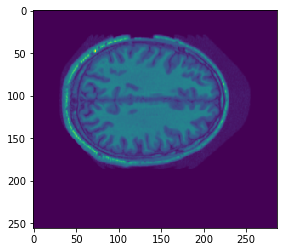

In [8]:
plt.imshow(i[0])

In [9]:
# import dipy
# import matplotlib.pylab as plt

# from dipy.data import get_data
# from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
# from dipy.align.metrics import SSDMetric, CCMetric, EMMetric
# import dipy.align.imwarp as imwarp
# from dipy.viz import regtools

In [10]:
# metric = SSDMetric(2)
# level_iters = [200, 100, 50, 25]
# sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter = 50)

In [11]:


# m1 = x[88].reshape([256,256])
# m2 = x[94].reshape([256,256])

# plt.imshow(m1); plt.colorbar(); plt.show()
# plt.imshow(m2); plt.colorbar(); plt.show()

# regtools.overlay_images(m1, m2, 'channel1', 'channel2', 'both channels', 'tmp.png');
# metric = SSDMetric(2)
# level_iters = [200, 100, 50, 25]
# sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter = 50)

# mapping = sdr.optimize(m1, m2)

# regtools.plot_2d_diffeomorphic_map(mapping, 10, 'diffeomorphic_map.png')
# warped_m2 = mapping.transform(m2, 'linear')

# regtools.overlay_images(m1, warped_m2, 'initial m1','Overlay','Warped m2', 'direct_warp_result.png')
# plt.imshow(warped_m2); plt.colorbar(); plt.show()

# plt.imshow(m1-warped_m2); plt.colorbar(); plt.show()
# plt.imshow(m1-m2); plt.colorbar(); plt.show()

In [7]:
num_seg = len(rest_available)+1

In [8]:
x_coordinate = np.zeros((256,256))
for i in range(256):
    x_coordinate[i:] = [i]*256    
y_coordinate = x_coordinate.copy()
y_coordinate = y_coordinate.T

In [9]:
x_coordinate = x_coordinate/255
y_coordinate = y_coordinate/255

In [10]:
class BrainImages(Dataset):
    def __init__(self, image_dir, label_dir, train_data = False, flipping = True, rotation = True, translation = True, \
                 coord = True):
        
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.flipping = flipping
        self.rotation = rotation
        self.translation = translation
        self.train_data = train_data
        self.coord = coord

    def __len__(self):
        return len(self.image_dir)

    def __getitem__(self,idx):
        image_path = "/gpfs/data/"+self.image_dir[idx]
        aseg_path = "/gpfs/data/"+self.label_dir[idx]
        
        img_orig = nibabel.freesurfer.mghformat.MGHImage.from_filename(image_path)
        image = img_orig.get_data().astype(np.float64)
        aseg_img = nibabel.freesurfer.mghformat.MGHImage.from_filename(aseg_path)
        aseg_img = aseg_img.get_data().astype(np.float64)

        flip = random.random() > 0.5
        angle = random.uniform(-10,10)
        dx = np.round(random.uniform(-25,25))
        dy = np.round(random.uniform(-25,25))
        
        im = Image.fromarray(image[0])
        target = Image.fromarray(aseg_img[0])
        if self.train_data:
            if self.flipping and flip:
                im = im.transpose(0)
                target = target.transpose(0)
            if self.rotation:
                im = im.rotate(angle)
                target = target.rotate(angle)
            if self.translation:
                im = im.transform((256,256),0, (1,0,dx,0,1,dy))
                target = target.transform((256,256),0,(1,0,dx,0,1,dy))
                
#        im = torch.from_numpy(np.array(im, np.float64, copy=False).reshape((1,256,256)))/255
        guassian_flag = random.random() > 0.5
        
        im = np.array(im, np.float64, copy=False)
        min_im = np.min(im)
        max_im = np.max(im)
        im = (im - min_im)/(max_im - min_im + 1e-4)
        if self.train_data and guassian_flag:
            sigma_rand = random.uniform(0.65,1.0)
            im_sigma = gaussian(im, sigma = sigma_rand)
            gamma_rand = random.uniform(1.6,2.4)
            im_sigma_gamma = exposure.adjust_gamma(im_sigma, gamma_rand)
            im = (im_sigma_gamma - np.min(im_sigma_gamma))/(np.max(im_sigma_gamma)-np.min(im_sigma_gamma)+1e-4)
        
        
        if self.coord:
            im = np.array([im, x_coordinate, y_coordinate], np.float64, copy=False)
            im = torch.from_numpy(im).type(torch.FloatTensor)
        else:
            im = torch.from_numpy(im).type(torch.FloatTensor).unsqueeze(0)

        target = np.array(target, np.float64, copy=False)
        target_label = np.zeros((len(rest_available)+1,256,256))
        for i,a in enumerate(available_segments):
            temp = (target==a).astype(int)
            if a in rest_available:
                target_label[rest_available.index(a),:,:] = temp
            else:
                target_label[len(rest_available),:,:] = target_label[len(rest_available),:,:] + temp
        target_label[len(rest_available),:,:] = (target_label[len(rest_available),:,:]>=1).astype(int) 
#        print(target_label.shape)
        target_label = torch.from_numpy(target_label).type(torch.FloatTensor)
        sample = {'x':im,'y':target_label} 
        return sample

In [11]:
file_names = pd.read_csv("all_complete_path.csv")

In [12]:
train_subjects = unpickling("train_subject_index")
val_subjects = unpickling("val_subject_index")
test_subjects = unpickling("test_subject_index")

In [13]:
full_train_raw = list(file_names.iloc[train_subjects,2])
full_train_seg = list(file_names.iloc[train_subjects,3])

full_val_raw = list(file_names.iloc[val_subjects,2])
full_val_seg = list(file_names.iloc[val_subjects,3])

full_test_raw = list(file_names.iloc[test_subjects,2])
full_test_seg = list(file_names.iloc[test_subjects,3])

In [14]:
277*18

4986

In [15]:
rand1 = np.arange(len(full_train_raw))
np.random.shuffle(rand1)
rand1 = rand1[:5000]

rand2 = np.arange(len(val_subjects))
np.random.shuffle(rand2)
rand2 = rand2[:1000]

rand3 = np.arange(len(test_subjects))
np.random.shuffle(rand3)
rand3 = rand3[:3]

In [16]:
cd = False
transformed_dataset = {'train': BrainImages(np.array(full_train_raw)[rand1],np.array(full_train_seg)[rand1], train_data= True, flipping=False, coord = cd),
                       'validate': BrainImages(np.array(full_val_raw)[rand2],np.array(full_val_seg)[rand2], coord = cd),
                       'test': BrainImages(np.array(full_test_raw)[rand3],np.array(full_test_seg)[rand3], coord = cd)
                                               }
bs = 12
dataloader = {x: DataLoader(transformed_dataset[x], batch_size=bs,
                        shuffle=True, num_workers=0) for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}

In [17]:
data = next(iter(dataloader['train']))

In [18]:
data['y'].size()

torch.Size([12, 46, 256, 256])

In [19]:
data['x'].size()

torch.Size([12, 1, 256, 256])

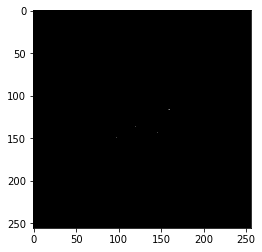

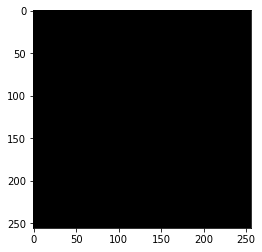

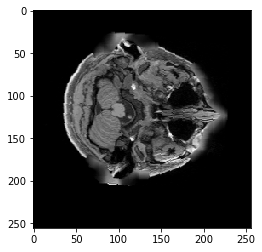

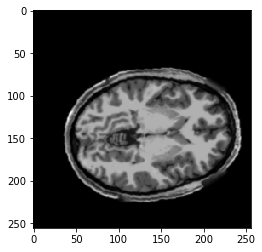

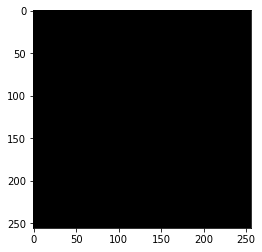

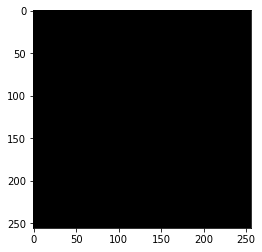

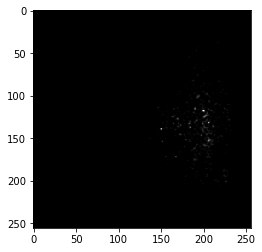

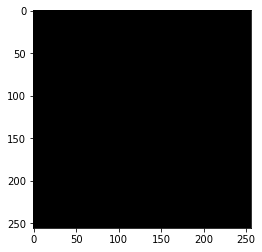

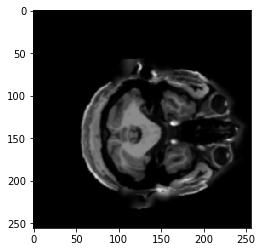

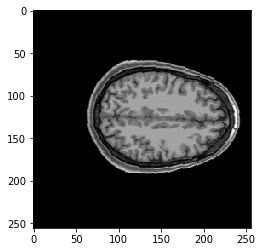

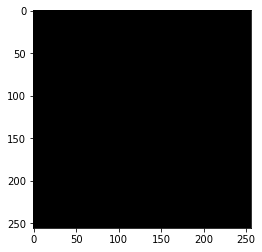

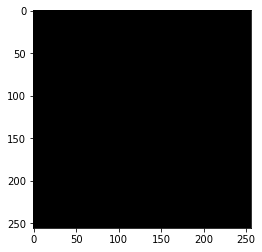

In [20]:
for i in range(bs):
    plt.imshow(data['x'][i,0,:,:],cmap='gray')
    plt.show()

In [25]:
# list_arr = []
# for data in dataloader["train"]:
#     y = data['y'].numpy()
#     N,C,_,_ = y.shape
#     sum_arr = np.sum(y.reshape(N,C,-1),axis = 2)
#     list_arr.append(sum_arr)
# final_arr = np.concatenate(list_arr,axis = 0)
# freq_class = np.true_divide(final_arr.sum(0),(final_arr!=0).sum(0)*(256*256))
# class_wts = np.median(freq_class)/freq_class
# pickling(class_wts,'new_class_wts_46_seg')

In [21]:
class_wts = unpickling('new_class_wts_46_seg')

In [22]:
class Downsample_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self,x):
        x = F.relu(self.bn1(self.conv1(x)))
        y = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(y, 2,stride = 2)
        
        return x, y

In [23]:
class Upsample_block(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(Upsample_block, self).__init__()
        self.transconv = nn.ConvTranspose2d(in_channels, out_channels, 4, padding = 1, stride = 2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self,x, y):
        x = self.transconv(x)
        x = torch.cat((x,y),dim = 1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        
        return x

In [24]:
class Unet(nn.Module):
    def __init__(self,in_chan = 3, out_chan = 3):
        super(Unet, self).__init__()
        self.down1 = Downsample_block(in_chan,64)
        self.down2 = Downsample_block(64,128)
        self.down3 = Downsample_block(128,256)
        self.down4 = Downsample_block(256,512)
        self.conv1 = nn.Conv2d(512,1024, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(1024)
        self.conv2 = nn.Conv2d(1024,1024,3, padding = 1)
        self.bn2 = nn.BatchNorm2d(1024)
        self.up4 = Upsample_block(1024,512)
        self.up3 = Upsample_block(512,256)
        self.up2 = Upsample_block(256,128)
        self.up1 = Upsample_block(128,64)
        self.outconv = nn.Conv2d(64,out_chan, 1)
        
    def forward(self,x):
        x, y1 = self.down1(x)
        x, y2 = self.down2(x)
        x, y3 = self.down3(x)
        x, y4 = self.down4(x)
        x = F.dropout2d(F.relu(self.bn1(self.conv1(x))))
        x = F.dropout2d(F.relu(self.bn2(self.conv2(x))))
        x = self.up4(x, y4)
        x = self.up3(x, y3)
        x = self.up2(x, y2)
        x = self.up1(x, y1)
        x = self.outconv(x)
        
        return x

In [25]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        I.xavier_normal(m.weight.data)

In [26]:
wts_torch = Variable(torch.from_numpy(class_wts)).cuda()

In [27]:
def get_gradient(true):
    true = true.data.cpu().numpy()
    N,C,sh1,sh2 = true.shape
    grads = []
    for i in range(N):
        grad_chan = []
        for j in range(C):
            sx = ndimage.sobel(true_out[i,j],axis=0,mode='constant')
            sy = ndimage.sobel(true_out[i,j],axis=1,mode='constant')
            sobel=np.hypot(sx,sy)
            grad_chan.append(sobel)
        grad_chan = np.vstack(grad_chan)
        grads.append(grad_chan)
    grads = np.vstack(grads)
    grads_mask = torch.from_numpy((np.absolute(grads)>0)).type(torch.cuda.FloatTensor)
    
    return grads_mask.view(N,C,-1)

In [28]:
def dice_loss_2(true,scores,mean, epsilon = 1e-4,p = 2,we = 0.05):
#     N, C, sh1, sh2 = true1.size()
    
#     true = []
#     scores = []
#     for c in range(N):
#         if not torch.sum(true1[c,1:,:,:])==0:
#             true.append(true1[c,:,:,:])
#             scores.append(scores1[c,:,:,:])
#     try:
#         true = torch.stack(true)
#         scores = torch.stack(scores)
#     except:
#         return -1
    
    
    
    N, C, sh1, sh2 = true.size()
#     grad_mask = get_gradient(true)
#     grad_mask = grad_mask.view(N,C,-1)
    
    preds = F.softmax(scores, dim = 1)
    true = true.view(N, C, -1)
    preds = preds.view(N, C, -1)
    wts = torch.sum(true, dim = 2) + epsilon
#     mean = 1/torch.pow(mean,p)
    wts[:,:] = mean[None].repeat(N,1)
#     wts = wts/(torch.sum(wts,dim = 1)[:,None])
#     print(wts)
    grad_wts = torch.max(mean)
    prod = torch.sum(true*preds,dim = 2)
    sum_tnp = torch.sum(true + preds, dim = 2)
    num = torch.sum(wts * prod, dim = 1)
    denom = torch.sum(wts * sum_tnp, dim = 1) + epsilon
    loss = 1 - 2*(num/denom)
    cel = -torch.sum(wts * torch.sum(true*torch.log(preds),dim = 2),dim = 1)
#     grad_loss = -torch.sum(2*grad_wts * torch.sum(grad_mask*torch.log(preds),dim = 2),dim = 1)
    return 40*torch.mean(loss)+we*torch.mean(cel)
#     return torch.mean(loss)

In [29]:
def dice_score(true,scores, epsilon = 1e-7):
#     N ,C, sh1, sh2 = true1.size()
#     true = []
#     scores = []
#     for c in range(N):
#         if not torch.sum(true1[c,1:,:,:])==0:
#             true.append(true1[c,:,:,:])
#             scores.append(scores1[c,:,:,:])
#     try:
#         true = torch.stack(true)
#         scores = torch.stack(scores)
#     except:
#         return 0
    
    N, C, sh1, sh2 = true.size()
    
    true = true.view(N,C,-1)
    preds = F.softmax(scores, dim = 1)
    pred_class = (torch.max(preds, dim = 1)[1]).view(N,-1)
    class_score = [0]*C
    for i in range(C):
        class_score[i] = (pred_class == i).data.type(torch.cuda.FloatTensor)
    true = true.data.type(torch.cuda.FloatTensor)
    def numerator(truth,pred, idx):
        return(torch.sum(truth[:,idx,:] * pred,dim = 1)) + epsilon/2
    def denominator(truth,pred,idx):
        return(torch.sum(truth[:,idx,:]+pred,dim = 1)) + epsilon
    dice_class_score = [0]*C
    for i in range(C):
        dice_class_score[i] = torch.mean(2*(numerator(true,class_score[i],i))/(denominator(true,class_score[i],i)))
    return dice_class_score
    

In [30]:
import time
def train_model(model, optimizer,dataloader, name,num_seg = 3, num_epochs = 100, verbose = False, every = 1,\
                print_all_ds = True):
    since = time.time()
    best_loss = np.inf
    best_score = 0
    loss_hist = {'train':[],'validate':[]}
    dice_scores_of_all_class = [{'train':[],'validate':[]} for i in range(num_seg)]    
    for i in range(num_epochs):
        for phase in ['train', 'validate']:
            running_loss = 0
            run_class_scores = [0]*num_seg
            running_total = 0
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)
    
            for data in dataloader[phase]:
                optimizer.zero_grad()
                x = data['x']
                y = data['y']
                x = Variable(x).cuda()
                y = Variable(y).cuda()
                N, C, sh1, sh2 = y.size()
                rand_num = np.random.rand()
                if rand_num < 0.90:
                    y_mask = (torch.sum(y[:,:(C-1),:,:].contiguous().view(N,-1),dim = 1) != 0)
                    y = y[y_mask]
                    x = x[y_mask]
#                 for sel in range(x.size()[0]):
#                     if torch.sum(y[sel,0,:,:]) != 0:
#                         y_sel.append(y[sel,:,:,:])
#                         x_sel.append(x[sel,:,:,:])

#                 try:
#                     y_sel = torch.stack(y_sel)
#                     output_sel = torch.stack(output_sel)
#                 except:
#                     continue
#                 output = model(x)
                try:
                    output = model(x)
                except:
                    continue
                loss = dice_loss_2(y, output,wts_torch)
                #loss = Variable(dice_loss_2(y_sel, output_sel,wts_torch),requires_grad=True)
                if loss==-1:
                    continue
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                running_loss += loss.data[0] * N
                running_total += N
                dice_score_batch = dice_score(y,output)

                for j in range(num_seg):
                    run_class_scores[j] += dice_score_batch[j] * N
            epoch_loss = running_loss/running_total
            loss_hist[phase].append(epoch_loss.item())
            epoch_score = 0
            for j in range(num_seg):
                score = run_class_scores[j]/running_total
                dice_scores_of_all_class[j][phase].append(score.item())
                if j < num_seg - 1:
                    epoch_score += score.item()
            epoch_score_av = epoch_score/ (num_seg - 1)
            if verbose or i%every == 0:
                print('Epoch: {}, Phase: {}, epoch loss: {:.4f}, Av. Dice Score: {:.4f}'\
                      .format(i,phase,epoch_loss,epoch_score_av))
#                 epoch_score = 0
                if print_all_ds:
                    for j in range(num_seg - 1):
                        print('Class {} (DS): {:.4f}'.format(j,dice_scores_of_all_class[j][phase][-1]))
    #                 epoch_score += dice_scores_of_all_class[j][phase][-1]
    #             epoch_score_av = epoch_score / (num_seg - 1)
                print('-'*10)
            
        if phase == 'validate' and epoch_score_av > best_score:
            best_loss = epoch_loss
            best_score = epoch_score_av
            best_model_wts = model.state_dict()
            torch.save(model,name)
        #print(i)
    print('-'*50)    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val dice loss: {:4f}, Best Average DS: {:4f}'.format(best_loss,best_score))
    
    model.load_state_dict(best_model_wts)
    pickling(loss_hist,name+'loss_hist')
    pickling(dice_scores_of_all_class,name+'dice_hist')
    
    return model, loss_hist, dice_scores_of_all_class

In [31]:
model = Unet(in_chan = 1,out_chan = num_seg).cuda()
model.apply(weights_init)
model = nn.DataParallel(model)
criterion = dice_loss_2
#scheduler = lr_scheduler.StepLR(optimizer,step_size = 15)

In [32]:
optimizer = optim.Adam(model.parameters(),lr = 1e-4)

In [33]:
model, loss_hist, dice_hist = train_model(model, optimizer,dataloader,'exp_1_dnc_then_d_lr_1e-4',num_seg = num_seg, num_epochs = 30,\
                                         every = 1, print_all_ds = True)

Epoch: 0, Phase: train, epoch loss: 159.3691, Av. Dice Score: 0.2087
Class 0 (DS): 0.4801
Class 1 (DS): 0.3658
Class 2 (DS): 0.0563
Class 3 (DS): 0.0226
Class 4 (DS): 0.1155
Class 5 (DS): 0.5621
Class 6 (DS): 0.3520
Class 7 (DS): 0.0482
Class 8 (DS): 0.0602
Class 9 (DS): 0.0011
Class 10 (DS): 0.0374
Class 11 (DS): 0.5105
Class 12 (DS): 0.0865
Class 13 (DS): 0.1806
Class 14 (DS): 0.0490
Class 15 (DS): 0.0073
Class 16 (DS): 0.7241
Class 17 (DS): 0.7275
Class 18 (DS): 0.1406
Class 19 (DS): 0.0477
Class 20 (DS): 0.4378
Class 21 (DS): 0.4041
Class 22 (DS): 0.1326
Class 23 (DS): 0.1233
Class 24 (DS): 0.1289
Class 25 (DS): 0.5708
Class 26 (DS): 0.1089
Class 27 (DS): 0.0670
Class 28 (DS): 0.1177
Class 29 (DS): 0.0612
Class 30 (DS): 0.0313
Class 31 (DS): 0.0309
Class 32 (DS): 0.0304
Class 33 (DS): 0.1466
Class 34 (DS): 0.9578
Class 35 (DS): 0.0202
Class 36 (DS): 0.1401
Class 37 (DS): 0.0412
Class 38 (DS): 0.0000
Class 39 (DS): 0.0157
Class 40 (DS): 0.8624
Class 41 (DS): 0.0348
Class 42 (DS): 0.

Epoch: 4, Phase: train, epoch loss: 59.5288, Av. Dice Score: 0.8677
Class 0 (DS): 0.7556
Class 1 (DS): 0.6776
Class 2 (DS): 0.8262
Class 3 (DS): 0.9061
Class 4 (DS): 0.8363
Class 5 (DS): 0.8184
Class 6 (DS): 0.9294
Class 7 (DS): 0.9185
Class 8 (DS): 0.9222
Class 9 (DS): 0.8645
Class 10 (DS): 0.8574
Class 11 (DS): 0.7397
Class 12 (DS): 0.8729
Class 13 (DS): 0.9151
Class 14 (DS): 0.9373
Class 15 (DS): 0.8575
Class 16 (DS): 0.9284
Class 17 (DS): 0.9221
Class 18 (DS): 0.9643
Class 19 (DS): 0.7854
Class 20 (DS): 0.7000
Class 21 (DS): 0.6620
Class 22 (DS): 0.8865
Class 23 (DS): 0.9316
Class 24 (DS): 0.8535
Class 25 (DS): 0.8366
Class 26 (DS): 0.9464
Class 27 (DS): 0.9304
Class 28 (DS): 0.9230
Class 29 (DS): 0.9312
Class 30 (DS): 0.8934
Class 31 (DS): 0.9269
Class 32 (DS): 0.9416
Class 33 (DS): 0.9202
Class 34 (DS): 0.9616
Class 35 (DS): 0.7479
Class 36 (DS): 0.9225
Class 37 (DS): 0.6739
Class 38 (DS): 0.8489
Class 39 (DS): 0.9219
Class 40 (DS): 0.9291
Class 41 (DS): 0.9083
Class 42 (DS): 0.8

Epoch: 8, Phase: train, epoch loss: 24.4730, Av. Dice Score: 0.9194
Class 0 (DS): 0.8752
Class 1 (DS): 0.8069
Class 2 (DS): 0.9487
Class 3 (DS): 0.9249
Class 4 (DS): 0.8965
Class 5 (DS): 0.9020
Class 6 (DS): 0.9431
Class 7 (DS): 0.9347
Class 8 (DS): 0.9433
Class 9 (DS): 0.9282
Class 10 (DS): 0.9230
Class 11 (DS): 0.8914
Class 12 (DS): 0.9206
Class 13 (DS): 0.9277
Class 14 (DS): 0.9540
Class 15 (DS): 0.9312
Class 16 (DS): 0.9480
Class 17 (DS): 0.9408
Class 18 (DS): 0.9787
Class 19 (DS): 0.8281
Class 20 (DS): 0.8737
Class 21 (DS): 0.8123
Class 22 (DS): 0.9521
Class 23 (DS): 0.9460
Class 24 (DS): 0.8989
Class 25 (DS): 0.9050
Class 26 (DS): 0.9521
Class 27 (DS): 0.9494
Class 28 (DS): 0.9524
Class 29 (DS): 0.9408
Class 30 (DS): 0.9210
Class 31 (DS): 0.9549
Class 32 (DS): 0.9505
Class 33 (DS): 0.9404
Class 34 (DS): 0.9775
Class 35 (DS): 0.8275
Class 36 (DS): 0.9596
Class 37 (DS): 0.8023
Class 38 (DS): 0.9324
Class 39 (DS): 0.9611
Class 40 (DS): 0.9600
Class 41 (DS): 0.9532
Class 42 (DS): 0.8

Epoch: 12, Phase: train, epoch loss: 18.8724, Av. Dice Score: 0.9278
Class 0 (DS): 0.9027
Class 1 (DS): 0.8459
Class 2 (DS): 0.9526
Class 3 (DS): 0.9340
Class 4 (DS): 0.8970
Class 5 (DS): 0.9070
Class 6 (DS): 0.9519
Class 7 (DS): 0.9432
Class 8 (DS): 0.9481
Class 9 (DS): 0.9366
Class 10 (DS): 0.9416
Class 11 (DS): 0.8994
Class 12 (DS): 0.9305
Class 13 (DS): 0.9375
Class 14 (DS): 0.9634
Class 15 (DS): 0.9369
Class 16 (DS): 0.9496
Class 17 (DS): 0.9491
Class 18 (DS): 0.9805
Class 19 (DS): 0.8436
Class 20 (DS): 0.8968
Class 21 (DS): 0.8474
Class 22 (DS): 0.9568
Class 23 (DS): 0.9516
Class 24 (DS): 0.9043
Class 25 (DS): 0.9139
Class 26 (DS): 0.9582
Class 27 (DS): 0.9512
Class 28 (DS): 0.9564
Class 29 (DS): 0.9462
Class 30 (DS): 0.9312
Class 31 (DS): 0.9594
Class 32 (DS): 0.9565
Class 33 (DS): 0.9502
Class 34 (DS): 0.9815
Class 35 (DS): 0.8374
Class 36 (DS): 0.9667
Class 37 (DS): 0.8011
Class 38 (DS): 0.9211
Class 39 (DS): 0.9646
Class 40 (DS): 0.9635
Class 41 (DS): 0.9526
Class 42 (DS): 0.

Epoch: 16, Phase: train, epoch loss: 17.2481, Av. Dice Score: 0.9303
Class 0 (DS): 0.9051
Class 1 (DS): 0.8550
Class 2 (DS): 0.9548
Class 3 (DS): 0.9401
Class 4 (DS): 0.9051
Class 5 (DS): 0.9213
Class 6 (DS): 0.9521
Class 7 (DS): 0.9465
Class 8 (DS): 0.9507
Class 9 (DS): 0.9315
Class 10 (DS): 0.9442
Class 11 (DS): 0.9038
Class 12 (DS): 0.9320
Class 13 (DS): 0.9376
Class 14 (DS): 0.9609
Class 15 (DS): 0.9390
Class 16 (DS): 0.9543
Class 17 (DS): 0.9506
Class 18 (DS): 0.9797
Class 19 (DS): 0.8389
Class 20 (DS): 0.9047
Class 21 (DS): 0.8665
Class 22 (DS): 0.9597
Class 23 (DS): 0.9615
Class 24 (DS): 0.9099
Class 25 (DS): 0.9224
Class 26 (DS): 0.9575
Class 27 (DS): 0.9520
Class 28 (DS): 0.9586
Class 29 (DS): 0.9417
Class 30 (DS): 0.9312
Class 31 (DS): 0.9625
Class 32 (DS): 0.9528
Class 33 (DS): 0.9524
Class 34 (DS): 0.9803
Class 35 (DS): 0.8373
Class 36 (DS): 0.9645
Class 37 (DS): 0.8117
Class 38 (DS): 0.9220
Class 39 (DS): 0.9656
Class 40 (DS): 0.9651
Class 41 (DS): 0.9559
Class 42 (DS): 0.

Epoch: 20, Phase: train, epoch loss: 16.0144, Av. Dice Score: 0.9347
Class 0 (DS): 0.9144
Class 1 (DS): 0.8692
Class 2 (DS): 0.9590
Class 3 (DS): 0.9465
Class 4 (DS): 0.9155
Class 5 (DS): 0.9246
Class 6 (DS): 0.9546
Class 7 (DS): 0.9506
Class 8 (DS): 0.9531
Class 9 (DS): 0.9350
Class 10 (DS): 0.9510
Class 11 (DS): 0.9107
Class 12 (DS): 0.9357
Class 13 (DS): 0.9411
Class 14 (DS): 0.9679
Class 15 (DS): 0.9434
Class 16 (DS): 0.9575
Class 17 (DS): 0.9516
Class 18 (DS): 0.9824
Class 19 (DS): 0.8492
Class 20 (DS): 0.9084
Class 21 (DS): 0.8694
Class 22 (DS): 0.9641
Class 23 (DS): 0.9589
Class 24 (DS): 0.9163
Class 25 (DS): 0.9169
Class 26 (DS): 0.9610
Class 27 (DS): 0.9559
Class 28 (DS): 0.9572
Class 29 (DS): 0.9477
Class 30 (DS): 0.9307
Class 31 (DS): 0.9611
Class 32 (DS): 0.9590
Class 33 (DS): 0.9556
Class 34 (DS): 0.9824
Class 35 (DS): 0.8480
Class 36 (DS): 0.9638
Class 37 (DS): 0.8156
Class 38 (DS): 0.9250
Class 39 (DS): 0.9673
Class 40 (DS): 0.9691
Class 41 (DS): 0.9604
Class 42 (DS): 0.

Epoch: 24, Phase: train, epoch loss: 15.0835, Av. Dice Score: 0.9371
Class 0 (DS): 0.9198
Class 1 (DS): 0.8704
Class 2 (DS): 0.9627
Class 3 (DS): 0.9480
Class 4 (DS): 0.9174
Class 5 (DS): 0.9275
Class 6 (DS): 0.9586
Class 7 (DS): 0.9534
Class 8 (DS): 0.9590
Class 9 (DS): 0.9396
Class 10 (DS): 0.9495
Class 11 (DS): 0.9134
Class 12 (DS): 0.9354
Class 13 (DS): 0.9450
Class 14 (DS): 0.9689
Class 15 (DS): 0.9429
Class 16 (DS): 0.9611
Class 17 (DS): 0.9588
Class 18 (DS): 0.9806
Class 19 (DS): 0.8540
Class 20 (DS): 0.9150
Class 21 (DS): 0.8782
Class 22 (DS): 0.9647
Class 23 (DS): 0.9609
Class 24 (DS): 0.9189
Class 25 (DS): 0.9286
Class 26 (DS): 0.9630
Class 27 (DS): 0.9560
Class 28 (DS): 0.9604
Class 29 (DS): 0.9443
Class 30 (DS): 0.9329
Class 31 (DS): 0.9639
Class 32 (DS): 0.9610
Class 33 (DS): 0.9545
Class 34 (DS): 0.9806
Class 35 (DS): 0.8493
Class 36 (DS): 0.9673
Class 37 (DS): 0.8177
Class 38 (DS): 0.9275
Class 39 (DS): 0.9693
Class 40 (DS): 0.9688
Class 41 (DS): 0.9624
Class 42 (DS): 0.

Epoch: 28, Phase: train, epoch loss: 14.3073, Av. Dice Score: 0.9394
Class 0 (DS): 0.9220
Class 1 (DS): 0.8787
Class 2 (DS): 0.9610
Class 3 (DS): 0.9498
Class 4 (DS): 0.9185
Class 5 (DS): 0.9289
Class 6 (DS): 0.9589
Class 7 (DS): 0.9537
Class 8 (DS): 0.9578
Class 9 (DS): 0.9384
Class 10 (DS): 0.9543
Class 11 (DS): 0.9147
Class 12 (DS): 0.9408
Class 13 (DS): 0.9447
Class 14 (DS): 0.9695
Class 15 (DS): 0.9513
Class 16 (DS): 0.9621
Class 17 (DS): 0.9589
Class 18 (DS): 0.9812
Class 19 (DS): 0.8567
Class 20 (DS): 0.9140
Class 21 (DS): 0.8855
Class 22 (DS): 0.9666
Class 23 (DS): 0.9632
Class 24 (DS): 0.9203
Class 25 (DS): 0.9265
Class 26 (DS): 0.9651
Class 27 (DS): 0.9573
Class 28 (DS): 0.9638
Class 29 (DS): 0.9493
Class 30 (DS): 0.9373
Class 31 (DS): 0.9662
Class 32 (DS): 0.9619
Class 33 (DS): 0.9580
Class 34 (DS): 0.9801
Class 35 (DS): 0.8515
Class 36 (DS): 0.9679
Class 37 (DS): 0.8234
Class 38 (DS): 0.9321
Class 39 (DS): 0.9684
Class 40 (DS): 0.9695
Class 41 (DS): 0.9654
Class 42 (DS): 0.

In [34]:
optimizer = optim.Adam(model.parameters(),lr = 5e-5)

In [36]:
def dice_loss_2(true,scores,mean, epsilon = 1e-4,p = 2,we = 0.05):
#     N, C, sh1, sh2 = true1.size()
    
#     true = []
#     scores = []
#     for c in range(N):
#         if not torch.sum(true1[c,1:,:,:])==0:
#             true.append(true1[c,:,:,:])
#             scores.append(scores1[c,:,:,:])
#     try:
#         true = torch.stack(true)
#         scores = torch.stack(scores)
#     except:
#         return -1
    
    
    
    N, C, sh1, sh2 = true.size()
#     grad_mask = get_gradient(true)
#     grad_mask = grad_mask.view(N,C,-1)
    
    preds = F.softmax(scores, dim = 1)
    true = true.view(N, C, -1)
    preds = preds.view(N, C, -1)
    wts = torch.sum(true, dim = 2) + epsilon
#     mean = 1/torch.pow(mean,p)
    wts[:,:] = mean[None].repeat(N,1)
#     wts = wts/(torch.sum(wts,dim = 1)[:,None])
#     print(wts)
    grad_wts = torch.max(mean)
    prod = torch.sum(true*preds,dim = 2)
    sum_tnp = torch.sum(true + preds, dim = 2)
    num = torch.sum(wts * prod, dim = 1)
    denom = torch.sum(wts * sum_tnp, dim = 1) + epsilon
    loss = 1 - 2*(num/denom)
#     cel = -torch.sum(wts * torch.sum(true*torch.log(preds),dim = 2),dim = 1)
#     grad_loss = -torch.sum(2*grad_wts * torch.sum(grad_mask*torch.log(preds),dim = 2),dim = 1)
#     return 40*torch.mean(loss)+we*torch.mean(cel)
    return torch.mean(loss)

In [37]:
model, loss_hist, dice_hist = train_model(model, optimizer,dataloader,'exp_2_dnc_then_d_lr_5e-5',num_seg = num_seg, num_epochs = 30,\
                                         every = 1, print_all_ds = True)

Epoch: 0, Phase: train, epoch loss: 0.1027, Av. Dice Score: 0.9467
Class 0 (DS): 0.9184
Class 1 (DS): 0.8789
Class 2 (DS): 0.9673
Class 3 (DS): 0.9574
Class 4 (DS): 0.9213
Class 5 (DS): 0.9424
Class 6 (DS): 0.9627
Class 7 (DS): 0.9606
Class 8 (DS): 0.9634
Class 9 (DS): 0.9431
Class 10 (DS): 0.9600
Class 11 (DS): 0.9321
Class 12 (DS): 0.9425
Class 13 (DS): 0.9643
Class 14 (DS): 0.9753
Class 15 (DS): 0.9581
Class 16 (DS): 0.9653
Class 17 (DS): 0.9579
Class 18 (DS): 0.9839
Class 19 (DS): 0.8654
Class 20 (DS): 0.9272
Class 21 (DS): 0.8967
Class 22 (DS): 0.9693
Class 23 (DS): 0.9705
Class 24 (DS): 0.9252
Class 25 (DS): 0.9391
Class 26 (DS): 0.9631
Class 27 (DS): 0.9642
Class 28 (DS): 0.9705
Class 29 (DS): 0.9587
Class 30 (DS): 0.9494
Class 31 (DS): 0.9744
Class 32 (DS): 0.9652
Class 33 (DS): 0.9573
Class 34 (DS): 0.9836
Class 35 (DS): 0.8611
Class 36 (DS): 0.9772
Class 37 (DS): 0.8454
Class 38 (DS): 0.9276
Class 39 (DS): 0.9736
Class 40 (DS): 0.9794
Class 41 (DS): 0.9711
Class 42 (DS): 0.92

Epoch: 4, Phase: train, epoch loss: 0.0807, Av. Dice Score: 0.9537
Class 0 (DS): 0.9333
Class 1 (DS): 0.9033
Class 2 (DS): 0.9700
Class 3 (DS): 0.9670
Class 4 (DS): 0.9237
Class 5 (DS): 0.9504
Class 6 (DS): 0.9682
Class 7 (DS): 0.9642
Class 8 (DS): 0.9675
Class 9 (DS): 0.9508
Class 10 (DS): 0.9663
Class 11 (DS): 0.9457
Class 12 (DS): 0.9486
Class 13 (DS): 0.9656
Class 14 (DS): 0.9806
Class 15 (DS): 0.9667
Class 16 (DS): 0.9668
Class 17 (DS): 0.9643
Class 18 (DS): 0.9863
Class 19 (DS): 0.8650
Class 20 (DS): 0.9343
Class 21 (DS): 0.9106
Class 22 (DS): 0.9733
Class 23 (DS): 0.9729
Class 24 (DS): 0.9298
Class 25 (DS): 0.9466
Class 26 (DS): 0.9702
Class 27 (DS): 0.9685
Class 28 (DS): 0.9711
Class 29 (DS): 0.9585
Class 30 (DS): 0.9558
Class 31 (DS): 0.9770
Class 32 (DS): 0.9670
Class 33 (DS): 0.9642
Class 34 (DS): 0.9844
Class 35 (DS): 0.8661
Class 36 (DS): 0.9904
Class 37 (DS): 0.8476
Class 38 (DS): 0.9611
Class 39 (DS): 0.9807
Class 40 (DS): 0.9834
Class 41 (DS): 0.9762
Class 42 (DS): 0.95

Epoch: 8, Phase: train, epoch loss: 0.0759, Av. Dice Score: 0.9553
Class 0 (DS): 0.9333
Class 1 (DS): 0.9059
Class 2 (DS): 0.9719
Class 3 (DS): 0.9703
Class 4 (DS): 0.9259
Class 5 (DS): 0.9528
Class 6 (DS): 0.9695
Class 7 (DS): 0.9656
Class 8 (DS): 0.9699
Class 9 (DS): 0.9536
Class 10 (DS): 0.9678
Class 11 (DS): 0.9430
Class 12 (DS): 0.9508
Class 13 (DS): 0.9667
Class 14 (DS): 0.9810
Class 15 (DS): 0.9682
Class 16 (DS): 0.9704
Class 17 (DS): 0.9660
Class 18 (DS): 0.9870
Class 19 (DS): 0.8728
Class 20 (DS): 0.9342
Class 21 (DS): 0.9120
Class 22 (DS): 0.9724
Class 23 (DS): 0.9771
Class 24 (DS): 0.9299
Class 25 (DS): 0.9464
Class 26 (DS): 0.9711
Class 27 (DS): 0.9684
Class 28 (DS): 0.9747
Class 29 (DS): 0.9609
Class 30 (DS): 0.9569
Class 31 (DS): 0.9778
Class 32 (DS): 0.9699
Class 33 (DS): 0.9652
Class 34 (DS): 0.9874
Class 35 (DS): 0.8696
Class 36 (DS): 0.9871
Class 37 (DS): 0.8494
Class 38 (DS): 0.9602
Class 39 (DS): 0.9815
Class 40 (DS): 0.9846
Class 41 (DS): 0.9789
Class 42 (DS): 0.95

Epoch: 12, Phase: train, epoch loss: 0.0744, Av. Dice Score: 0.9547
Class 0 (DS): 0.9307
Class 1 (DS): 0.9004
Class 2 (DS): 0.9703
Class 3 (DS): 0.9695
Class 4 (DS): 0.9231
Class 5 (DS): 0.9519
Class 6 (DS): 0.9683
Class 7 (DS): 0.9641
Class 8 (DS): 0.9701
Class 9 (DS): 0.9534
Class 10 (DS): 0.9651
Class 11 (DS): 0.9431
Class 12 (DS): 0.9462
Class 13 (DS): 0.9673
Class 14 (DS): 0.9799
Class 15 (DS): 0.9684
Class 16 (DS): 0.9681
Class 17 (DS): 0.9654
Class 18 (DS): 0.9861
Class 19 (DS): 0.8696
Class 20 (DS): 0.9342
Class 21 (DS): 0.9088
Class 22 (DS): 0.9724
Class 23 (DS): 0.9749
Class 24 (DS): 0.9290
Class 25 (DS): 0.9471
Class 26 (DS): 0.9686
Class 27 (DS): 0.9683
Class 28 (DS): 0.9744
Class 29 (DS): 0.9615
Class 30 (DS): 0.9588
Class 31 (DS): 0.9769
Class 32 (DS): 0.9683
Class 33 (DS): 0.9660
Class 34 (DS): 0.9871
Class 35 (DS): 0.8698
Class 36 (DS): 0.9881
Class 37 (DS): 0.8512
Class 38 (DS): 0.9622
Class 39 (DS): 0.9810
Class 40 (DS): 0.9839
Class 41 (DS): 0.9791
Class 42 (DS): 0.9

Epoch: 16, Phase: train, epoch loss: 0.0718, Av. Dice Score: 0.9552
Class 0 (DS): 0.9312
Class 1 (DS): 0.9040
Class 2 (DS): 0.9707
Class 3 (DS): 0.9693
Class 4 (DS): 0.9247
Class 5 (DS): 0.9502
Class 6 (DS): 0.9693
Class 7 (DS): 0.9656
Class 8 (DS): 0.9695
Class 9 (DS): 0.9547
Class 10 (DS): 0.9673
Class 11 (DS): 0.9448
Class 12 (DS): 0.9458
Class 13 (DS): 0.9662
Class 14 (DS): 0.9812
Class 15 (DS): 0.9687
Class 16 (DS): 0.9686
Class 17 (DS): 0.9650
Class 18 (DS): 0.9871
Class 19 (DS): 0.8713
Class 20 (DS): 0.9328
Class 21 (DS): 0.9058
Class 22 (DS): 0.9722
Class 23 (DS): 0.9753
Class 24 (DS): 0.9280
Class 25 (DS): 0.9425
Class 26 (DS): 0.9715
Class 27 (DS): 0.9691
Class 28 (DS): 0.9737
Class 29 (DS): 0.9619
Class 30 (DS): 0.9607
Class 31 (DS): 0.9777
Class 32 (DS): 0.9698
Class 33 (DS): 0.9662
Class 34 (DS): 0.9879
Class 35 (DS): 0.8739
Class 36 (DS): 0.9891
Class 37 (DS): 0.8524
Class 38 (DS): 0.9648
Class 39 (DS): 0.9817
Class 40 (DS): 0.9855
Class 41 (DS): 0.9799
Class 42 (DS): 0.9

Epoch: 20, Phase: train, epoch loss: 0.0709, Av. Dice Score: 0.9549
Class 0 (DS): 0.9315
Class 1 (DS): 0.9038
Class 2 (DS): 0.9715
Class 3 (DS): 0.9694
Class 4 (DS): 0.9265
Class 5 (DS): 0.9479
Class 6 (DS): 0.9664
Class 7 (DS): 0.9655
Class 8 (DS): 0.9706
Class 9 (DS): 0.9546
Class 10 (DS): 0.9694
Class 11 (DS): 0.9450
Class 12 (DS): 0.9483
Class 13 (DS): 0.9670
Class 14 (DS): 0.9797
Class 15 (DS): 0.9676
Class 16 (DS): 0.9675
Class 17 (DS): 0.9647
Class 18 (DS): 0.9850
Class 19 (DS): 0.8688
Class 20 (DS): 0.9313
Class 21 (DS): 0.9113
Class 22 (DS): 0.9725
Class 23 (DS): 0.9761
Class 24 (DS): 0.9306
Class 25 (DS): 0.9425
Class 26 (DS): 0.9709
Class 27 (DS): 0.9690
Class 28 (DS): 0.9743
Class 29 (DS): 0.9608
Class 30 (DS): 0.9585
Class 31 (DS): 0.9775
Class 32 (DS): 0.9701
Class 33 (DS): 0.9643
Class 34 (DS): 0.9868
Class 35 (DS): 0.8684
Class 36 (DS): 0.9884
Class 37 (DS): 0.8521
Class 38 (DS): 0.9638
Class 39 (DS): 0.9791
Class 40 (DS): 0.9840
Class 41 (DS): 0.9789
Class 42 (DS): 0.9

Epoch: 24, Phase: train, epoch loss: 0.0690, Av. Dice Score: 0.9562
Class 0 (DS): 0.9351
Class 1 (DS): 0.9039
Class 2 (DS): 0.9719
Class 3 (DS): 0.9712
Class 4 (DS): 0.9280
Class 5 (DS): 0.9498
Class 6 (DS): 0.9679
Class 7 (DS): 0.9658
Class 8 (DS): 0.9710
Class 9 (DS): 0.9575
Class 10 (DS): 0.9679
Class 11 (DS): 0.9446
Class 12 (DS): 0.9505
Class 13 (DS): 0.9683
Class 14 (DS): 0.9813
Class 15 (DS): 0.9691
Class 16 (DS): 0.9687
Class 17 (DS): 0.9648
Class 18 (DS): 0.9862
Class 19 (DS): 0.8775
Class 20 (DS): 0.9373
Class 21 (DS): 0.9132
Class 22 (DS): 0.9719
Class 23 (DS): 0.9755
Class 24 (DS): 0.9293
Class 25 (DS): 0.9453
Class 26 (DS): 0.9707
Class 27 (DS): 0.9675
Class 28 (DS): 0.9748
Class 29 (DS): 0.9616
Class 30 (DS): 0.9623
Class 31 (DS): 0.9794
Class 32 (DS): 0.9699
Class 33 (DS): 0.9645
Class 34 (DS): 0.9876
Class 35 (DS): 0.8725
Class 36 (DS): 0.9875
Class 37 (DS): 0.8572
Class 38 (DS): 0.9613
Class 39 (DS): 0.9819
Class 40 (DS): 0.9846
Class 41 (DS): 0.9803
Class 42 (DS): 0.9

Epoch: 28, Phase: train, epoch loss: 0.0668, Av. Dice Score: 0.9569
Class 0 (DS): 0.9344
Class 1 (DS): 0.9093
Class 2 (DS): 0.9723
Class 3 (DS): 0.9725
Class 4 (DS): 0.9271
Class 5 (DS): 0.9527
Class 6 (DS): 0.9684
Class 7 (DS): 0.9676
Class 8 (DS): 0.9706
Class 9 (DS): 0.9605
Class 10 (DS): 0.9686
Class 11 (DS): 0.9474
Class 12 (DS): 0.9451
Class 13 (DS): 0.9678
Class 14 (DS): 0.9805
Class 15 (DS): 0.9702
Class 16 (DS): 0.9687
Class 17 (DS): 0.9663
Class 18 (DS): 0.9872
Class 19 (DS): 0.8712
Class 20 (DS): 0.9367
Class 21 (DS): 0.9145
Class 22 (DS): 0.9728
Class 23 (DS): 0.9785
Class 24 (DS): 0.9296
Class 25 (DS): 0.9471
Class 26 (DS): 0.9699
Class 27 (DS): 0.9696
Class 28 (DS): 0.9737
Class 29 (DS): 0.9630
Class 30 (DS): 0.9605
Class 31 (DS): 0.9793
Class 32 (DS): 0.9697
Class 33 (DS): 0.9677
Class 34 (DS): 0.9889
Class 35 (DS): 0.8726
Class 36 (DS): 0.9892
Class 37 (DS): 0.8586
Class 38 (DS): 0.9645
Class 39 (DS): 0.9809
Class 40 (DS): 0.9856
Class 41 (DS): 0.9825
Class 42 (DS): 0.9

In [ ]:
optimizer = optim.Adam(model.parameters(),lr = 1e-5)

In [ ]:
model, loss_hist, dice_hist = train_model(model, optimizer,dataloader,'exp_3_dnc_then_d_lr_1e-5',num_seg = num_seg, num_epochs = 30,\
                                         every = 1, print_all_ds = True)

In [ ]:
def dice_loss_2(true,scores,mean, epsilon = 1e-4,p = 2,we = 0.05):
#     N, C, sh1, sh2 = true1.size()
    
#     true = []
#     scores = []
#     for c in range(N):
#         if not torch.sum(true1[c,1:,:,:])==0:
#             true.append(true1[c,:,:,:])
#             scores.append(scores1[c,:,:,:])
#     try:
#         true = torch.stack(true)
#         scores = torch.stack(scores)
#     except:
#         return -1
    
    
    
    N, C, sh1, sh2 = true.size()
#     grad_mask = get_gradient(true)
#     grad_mask = grad_mask.view(N,C,-1)
    
    preds = F.softmax(scores, dim = 1)
    true = true.view(N, C, -1)
    preds = preds.view(N, C, -1)
    wts = torch.sum(true, dim = 2) + epsilon
#     mean = 1/torch.pow(mean,p)
    wts[:,:] = mean[None].repeat(N,1)
#     wts = wts/(torch.sum(wts,dim = 1)[:,None])
#     print(wts)
    grad_wts = torch.max(mean)
    prod = torch.sum(true*preds,dim = 2)
    sum_tnp = torch.sum(true + preds, dim = 2)
    num = torch.sum(wts * prod, dim = 1)
    denom = torch.sum(wts * sum_tnp, dim = 1) + epsilon
    loss = 1 - 2*(num/denom)
#     cel = -torch.sum(wts * torch.sum(true*torch.log(preds),dim = 2),dim = 1)
#     grad_loss = -torch.sum(2*grad_wts * torch.sum(grad_mask*torch.log(preds),dim = 2),dim = 1)
#     return 40*torch.mean(loss)+we*torch.mean(cel)
    return torch.mean(loss)

In [ ]:
model, loss_hist, dice_hist = train_model(model, optimizer,dataloader,'exp_4_dnc_then_d_lr_1e-5',num_seg = num_seg, num_epochs = 30,\
                                         every = 1, print_all_ds = True)

In [ ]:
#most recent model
#guassian_gamma_v1_4

In [38]:
def visualize1(image):
    p = F.softmax(image,dim = 0)
    p_maxim = torch.max(p, dim=0)[1]
    img = []
    for seg in range(num_seg):
        masked = (p_maxim==seg).data.type(torch.cuda.FloatTensor)
        img.append(masked)
    return torch.stack(img).unsqueeze(1).cpu()

In [39]:
%matplotlib inline
def show(img):    
    npimg = img.numpy()
    plt.figure(figsize = (20,20))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()

In [40]:
def visualize_few():
    data = next(iter(dataloader["validate"]))
    model.train(False)
    x = data['x']
    y = data['y']
    x = Variable(x).cuda()
    y = Variable(y).cuda()
                
    output = model(x)
    for i in range(bs):
        print('-'*100)
        print('Ground Truth')
        abc = data['y'][i,:,:,:]
        bcd = abc.unsqueeze(1)
        show(make_grid(bcd,padding=10,pad_value=1)) 
        print('-'*100)
        print('Prediction')
        show(make_grid(visualize1(output[i,:,:,:]),padding=10,pad_value=1))

----------------------------------------------------------------------------------------------------
Ground Truth


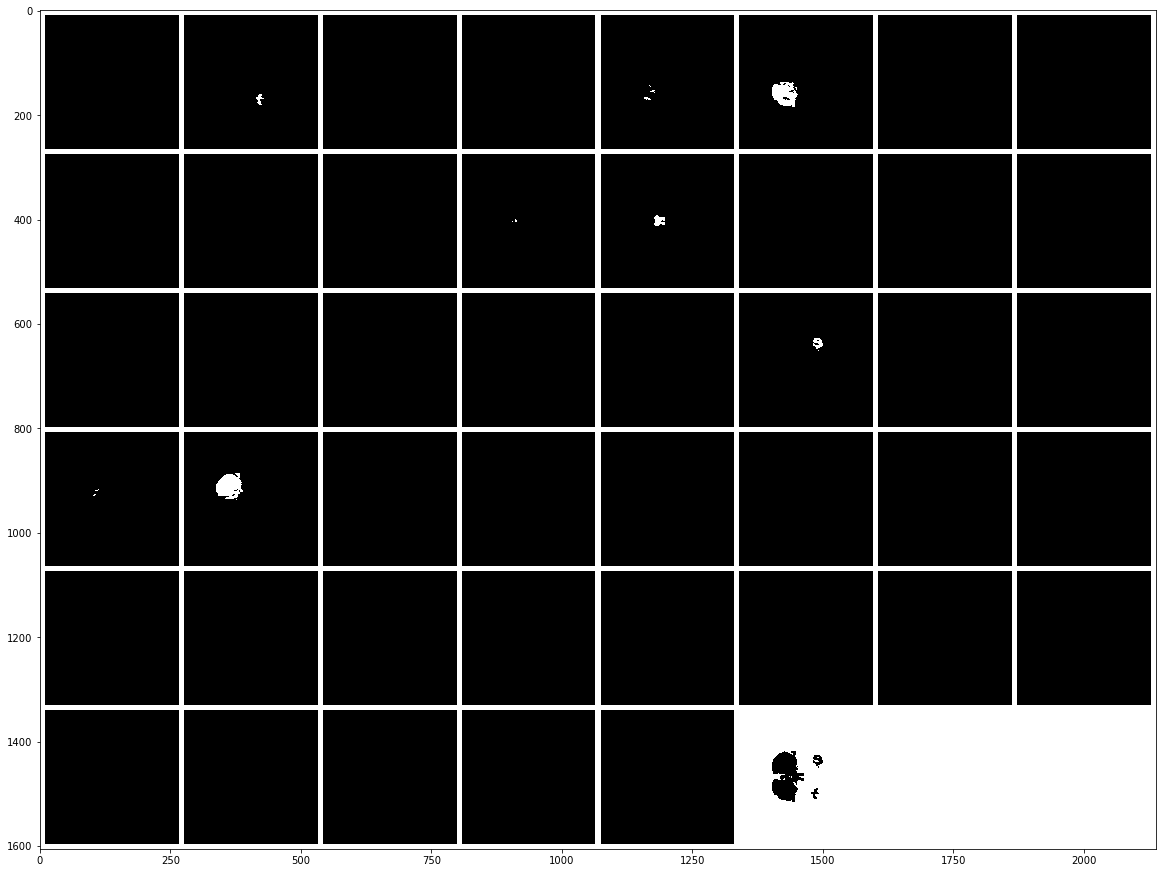

----------------------------------------------------------------------------------------------------
Prediction


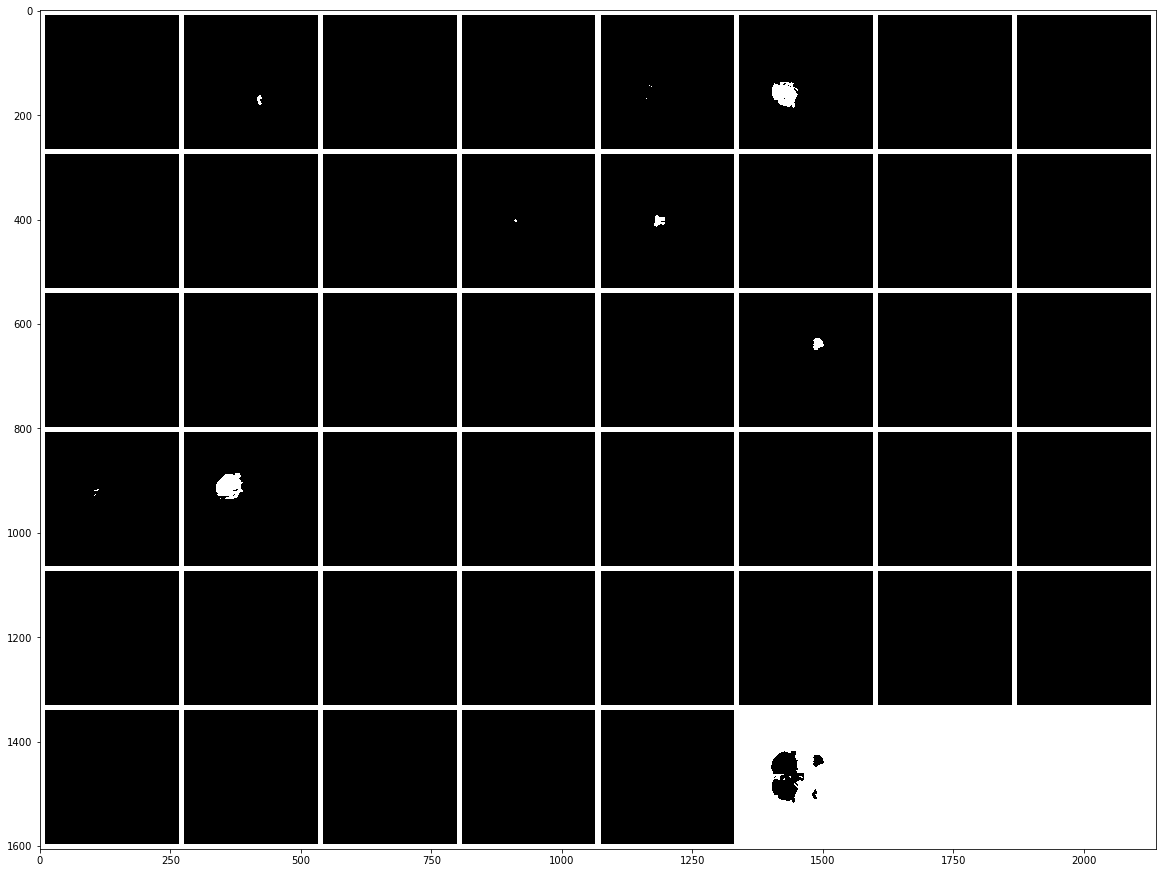

----------------------------------------------------------------------------------------------------
Ground Truth


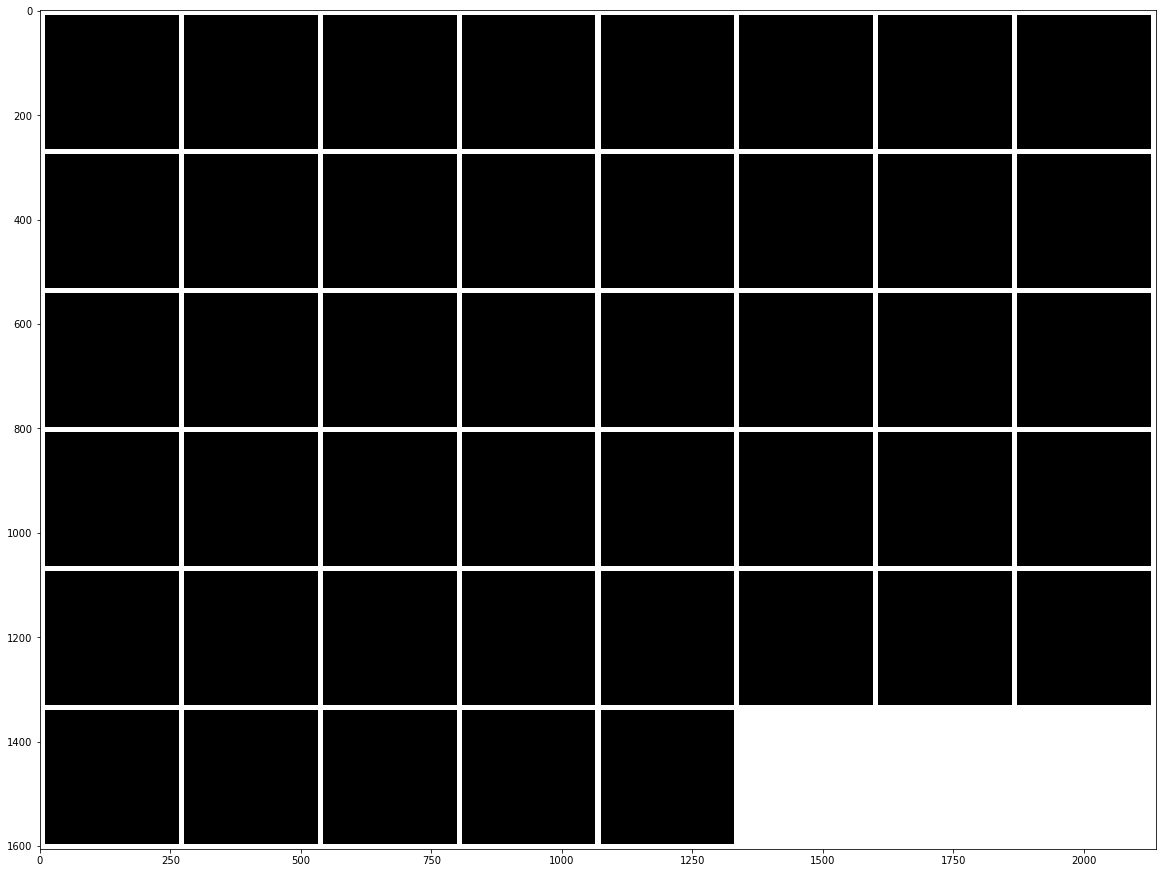

----------------------------------------------------------------------------------------------------
Prediction


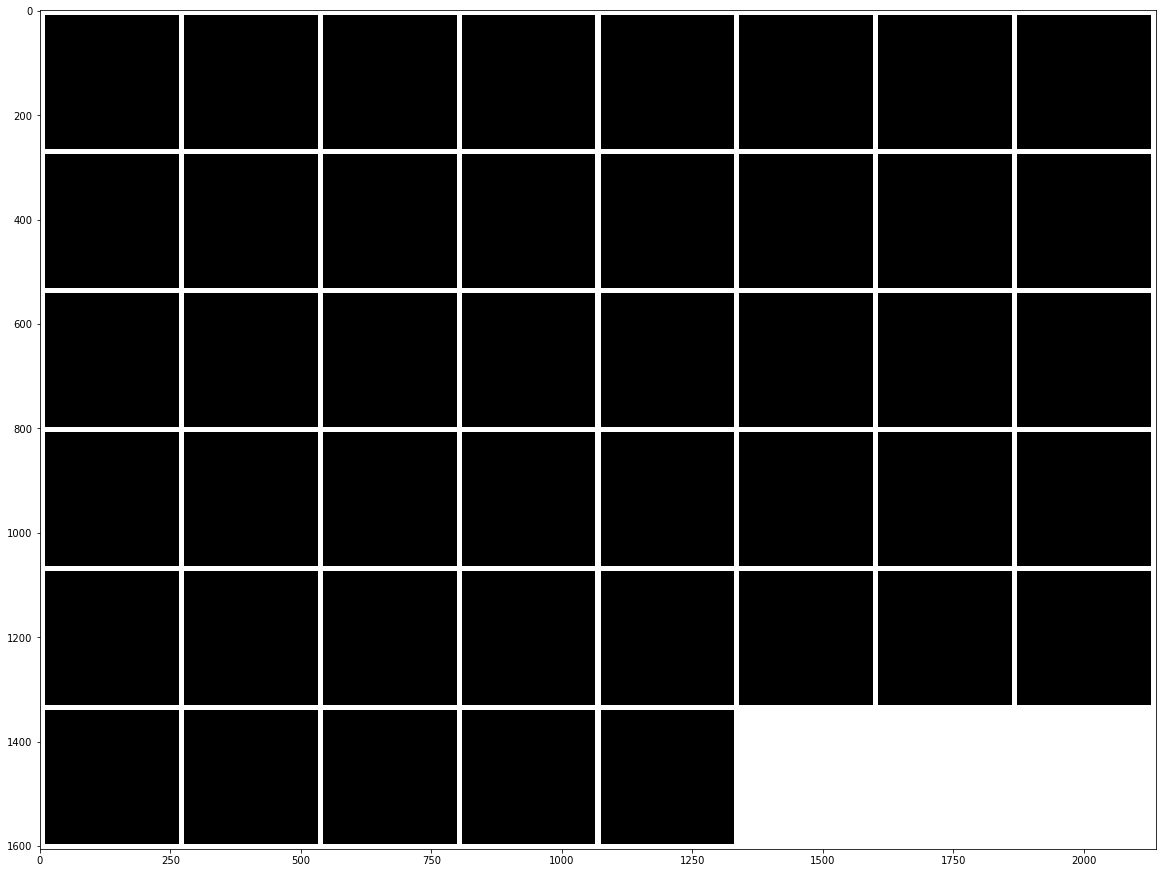

----------------------------------------------------------------------------------------------------
Ground Truth


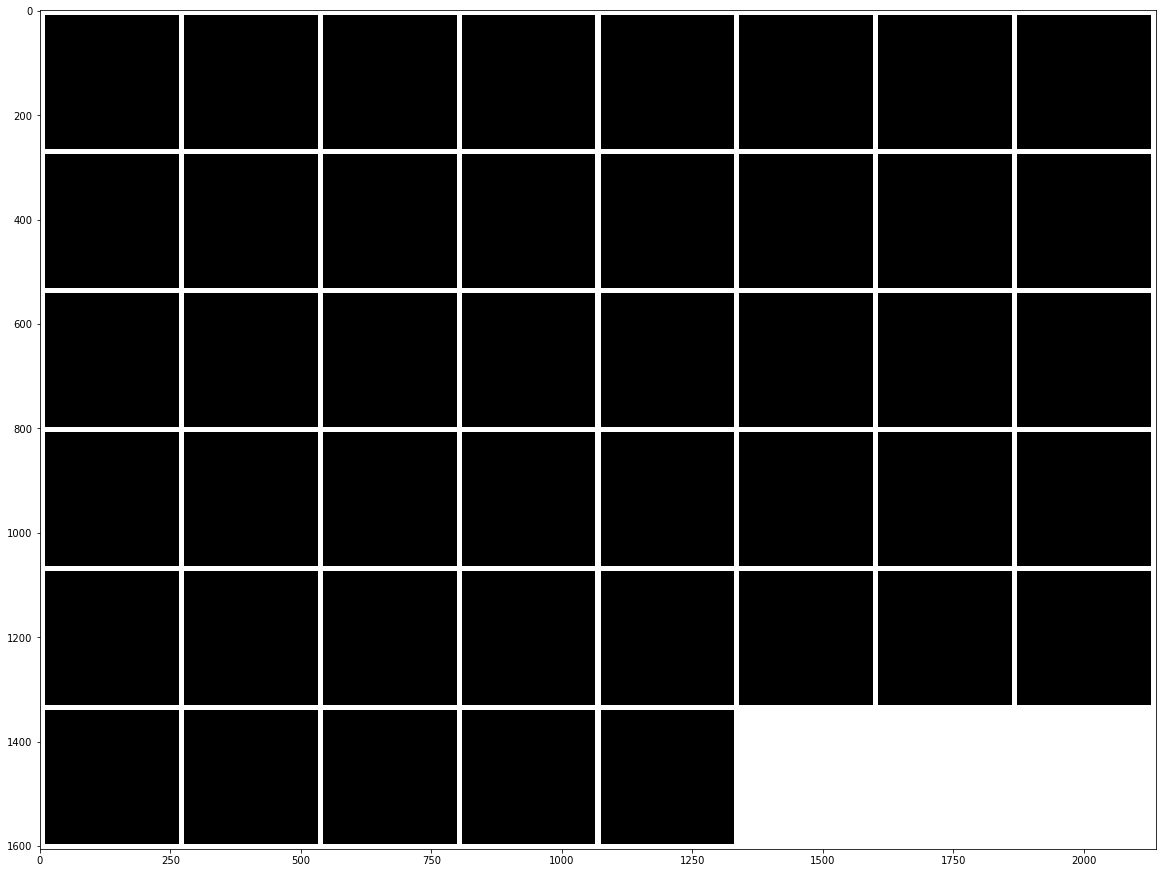

----------------------------------------------------------------------------------------------------
Prediction


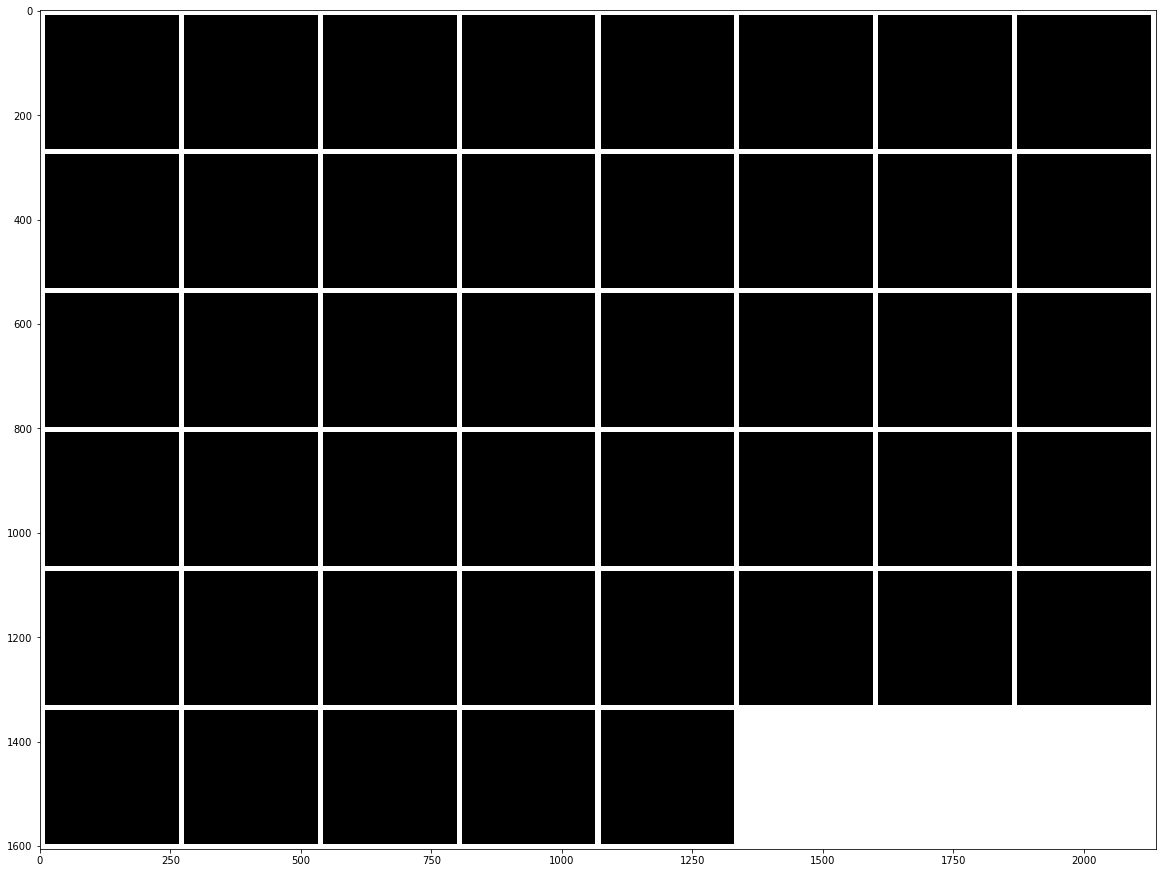

----------------------------------------------------------------------------------------------------
Ground Truth


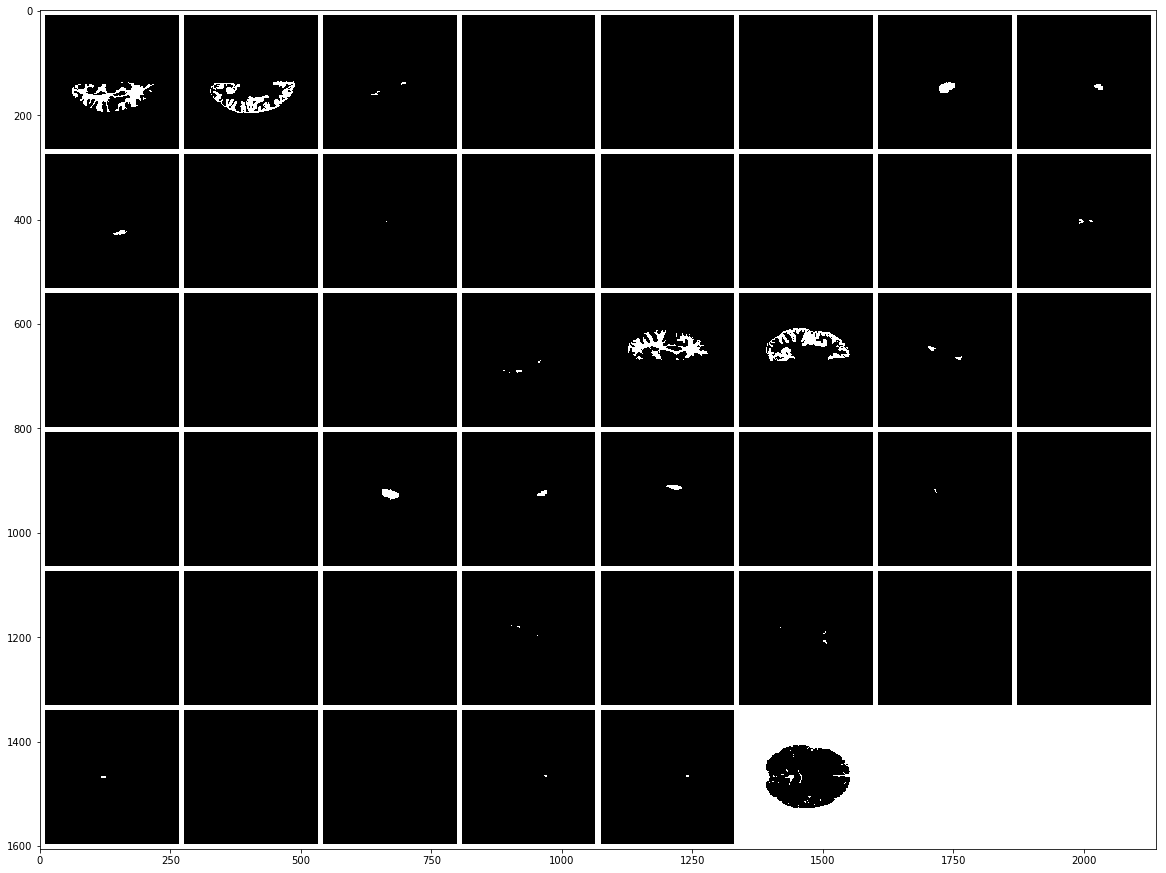

----------------------------------------------------------------------------------------------------
Prediction


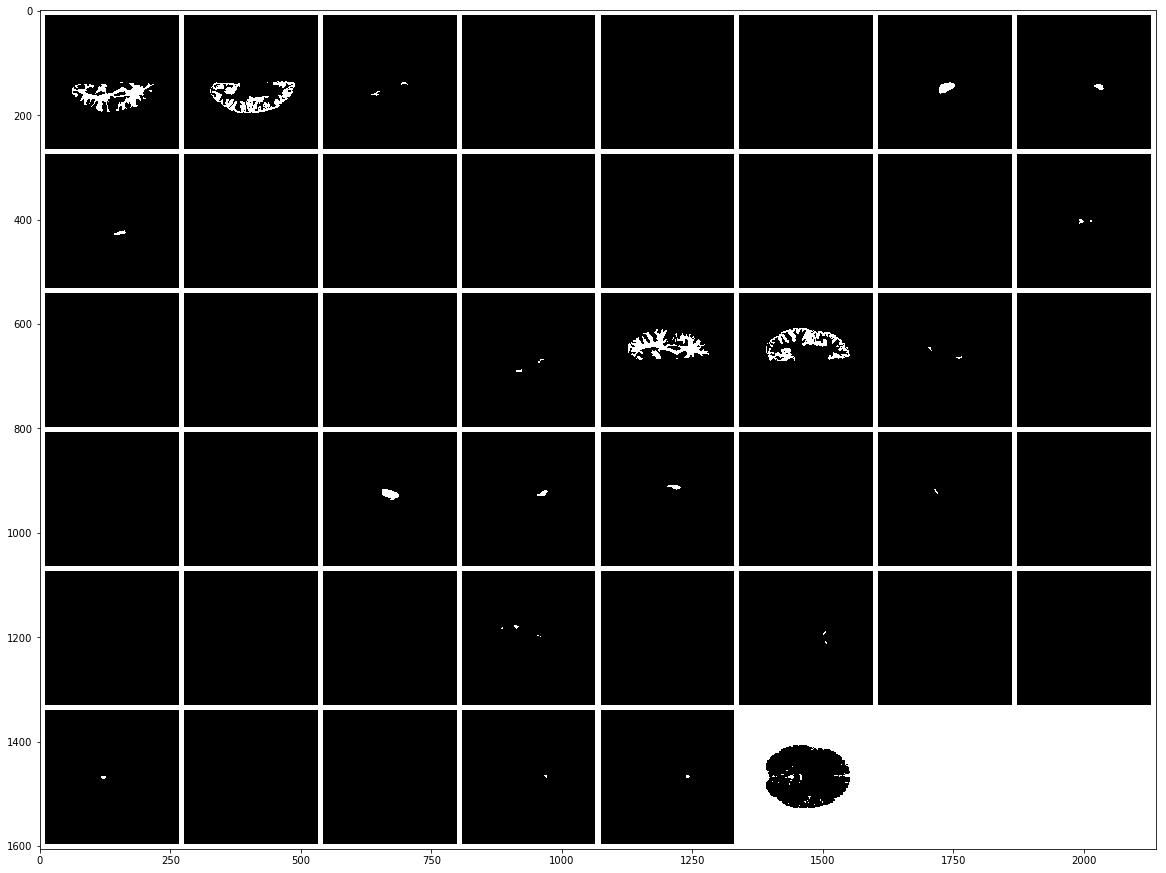

----------------------------------------------------------------------------------------------------
Ground Truth


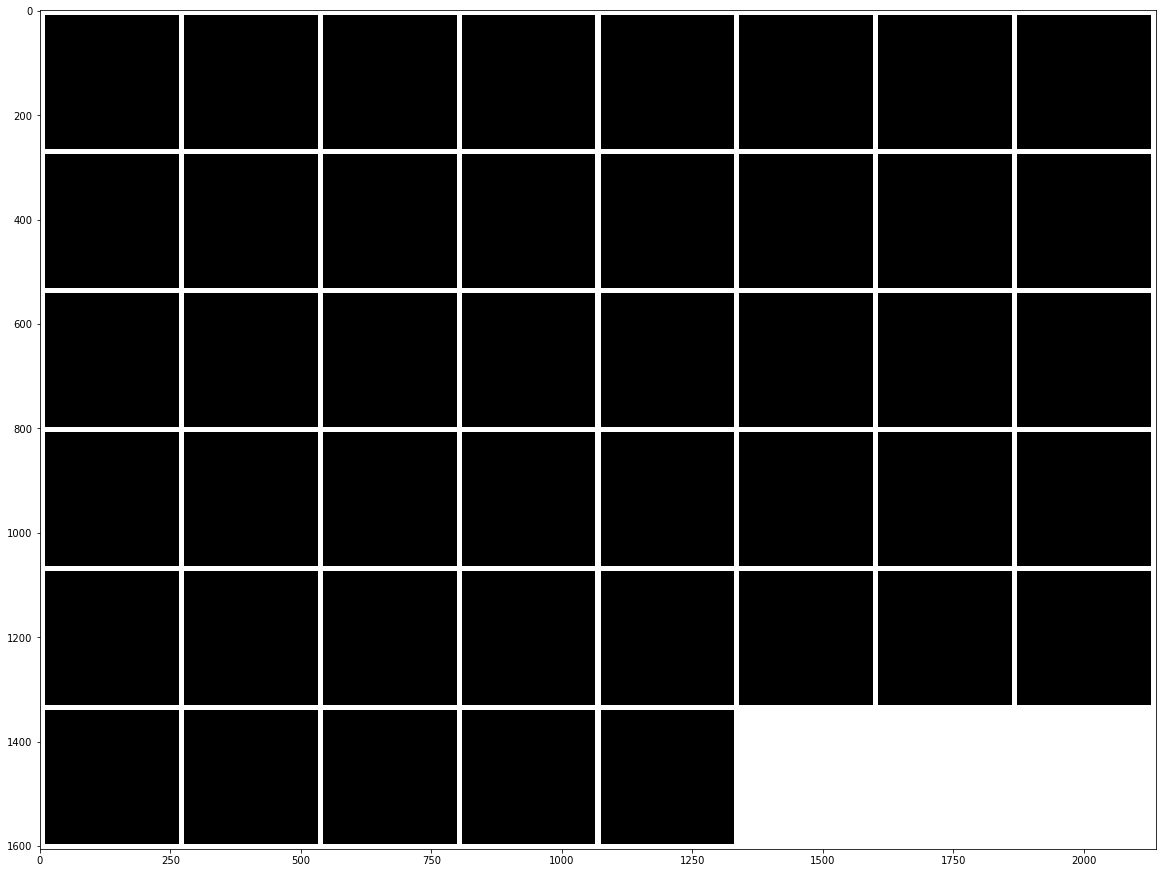

----------------------------------------------------------------------------------------------------
Prediction


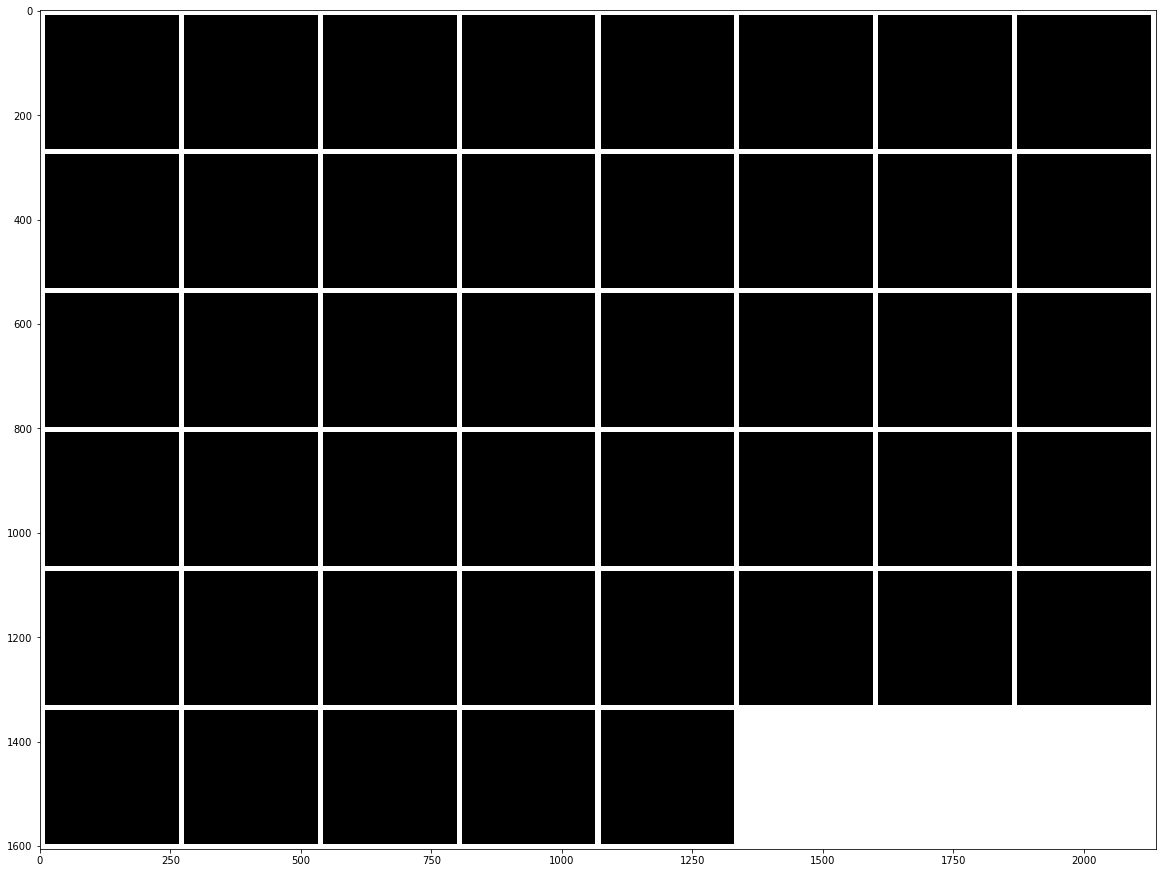

----------------------------------------------------------------------------------------------------
Ground Truth


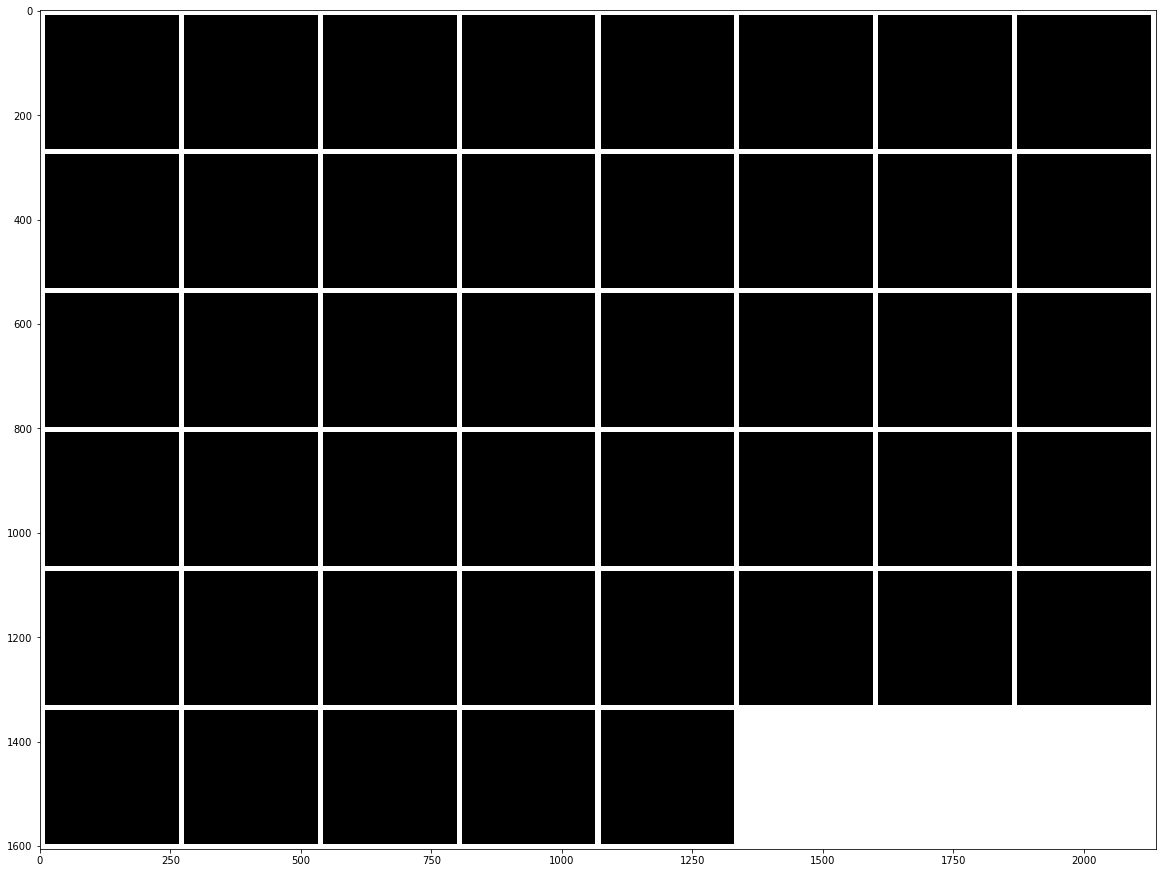

----------------------------------------------------------------------------------------------------
Prediction


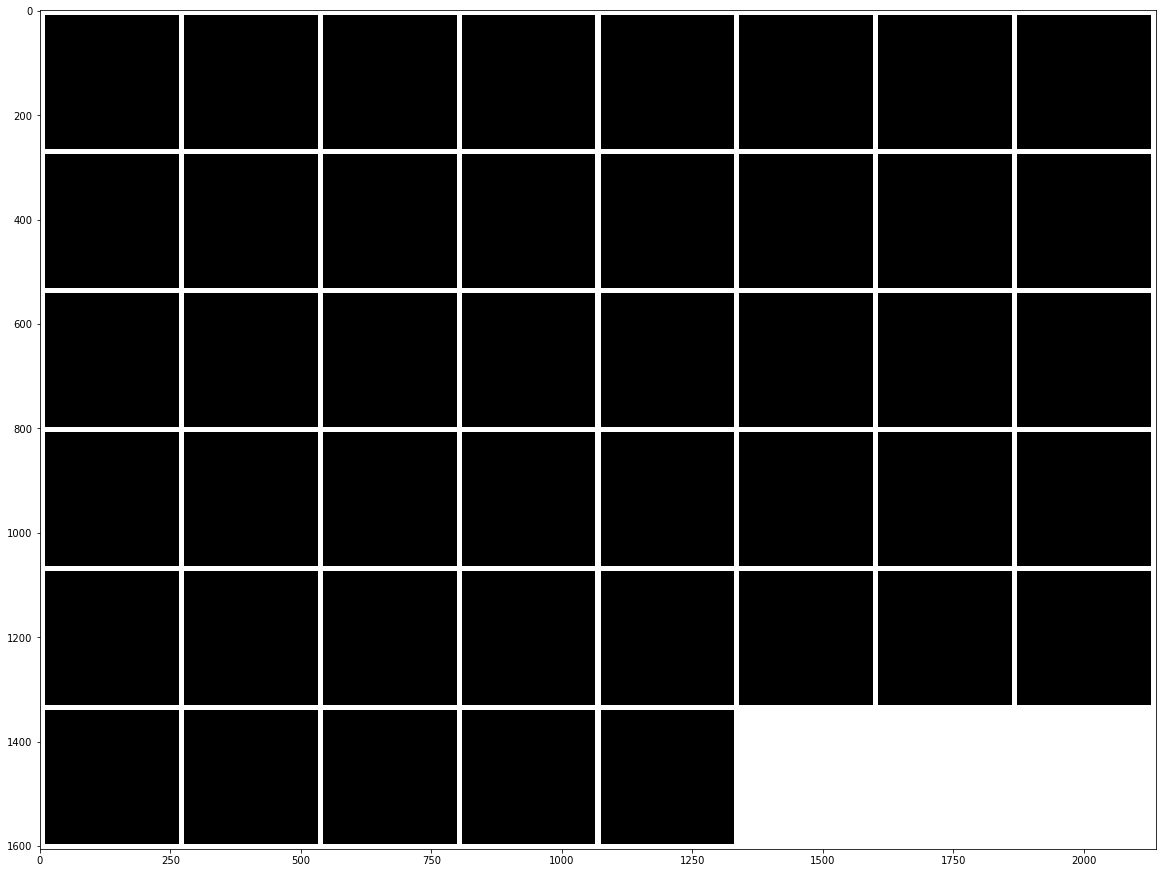

----------------------------------------------------------------------------------------------------
Ground Truth


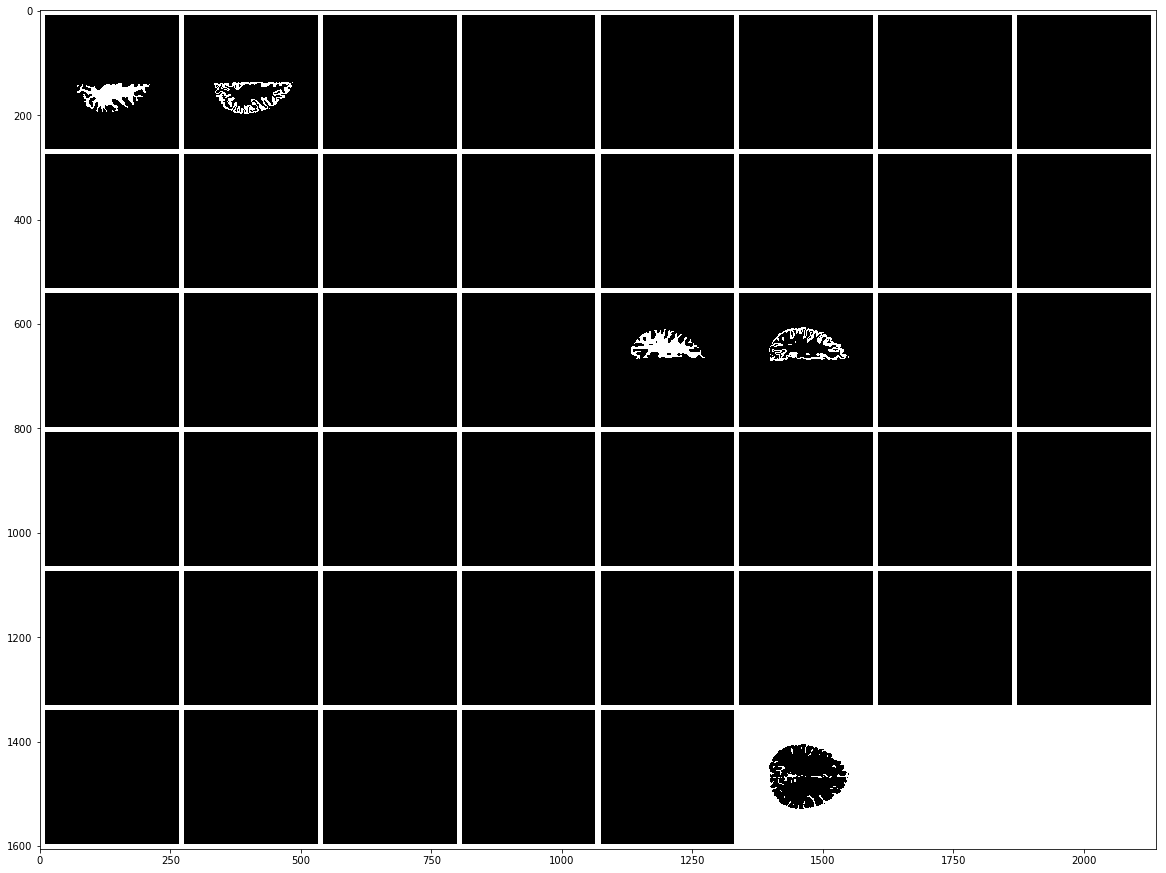

----------------------------------------------------------------------------------------------------
Prediction


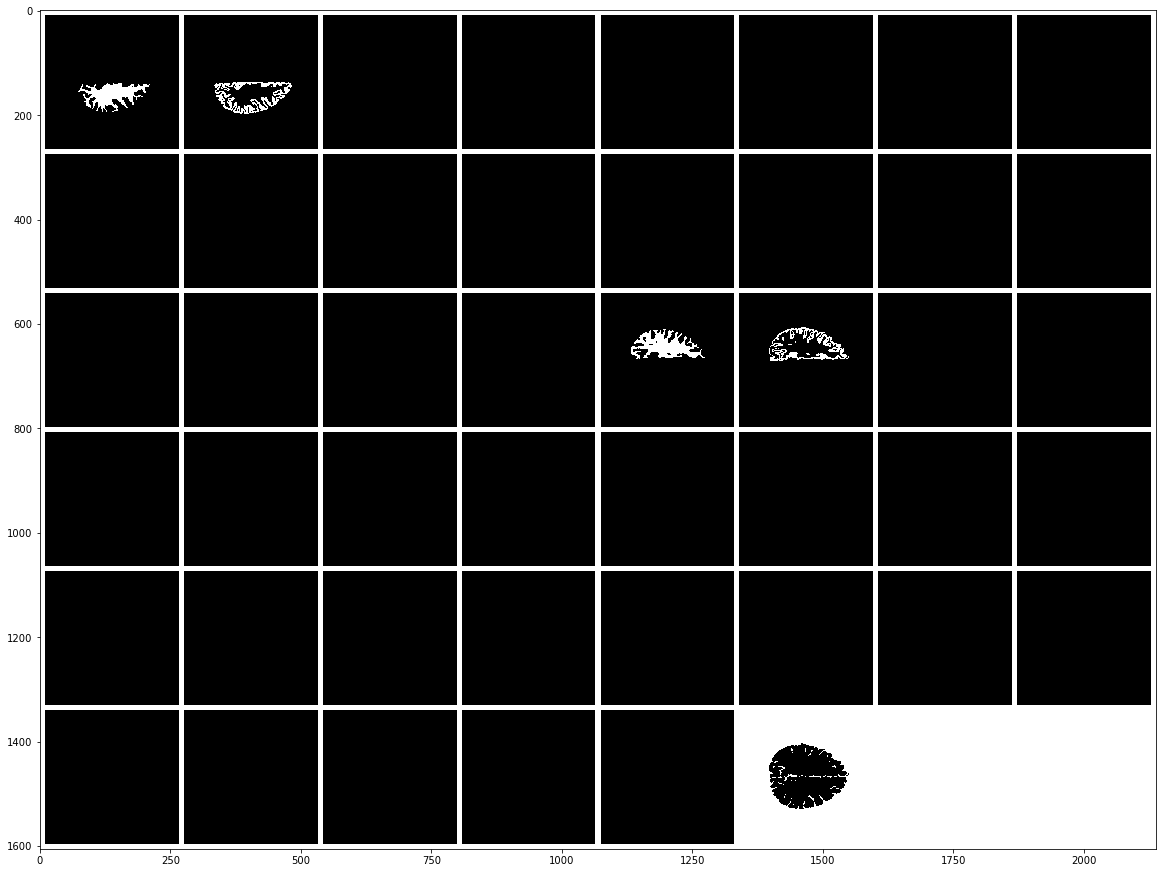

----------------------------------------------------------------------------------------------------
Ground Truth


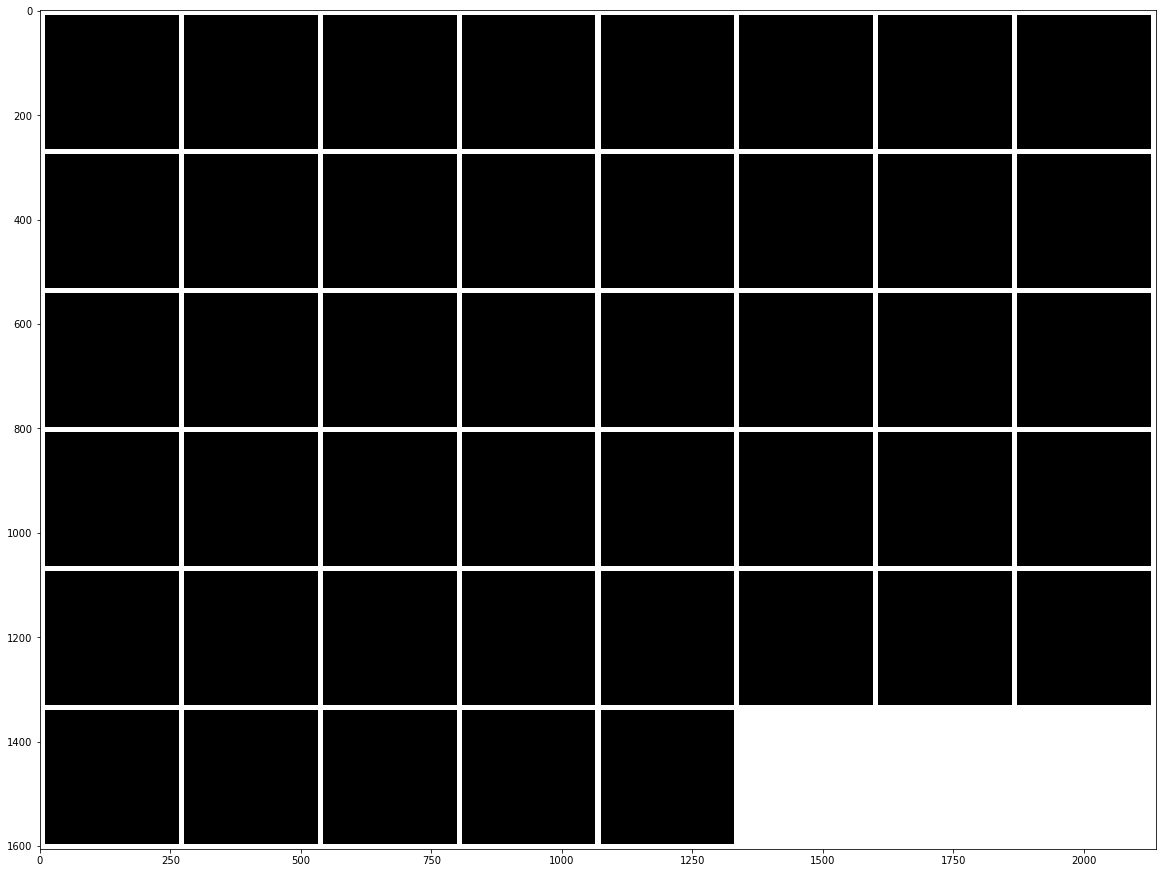

----------------------------------------------------------------------------------------------------
Prediction


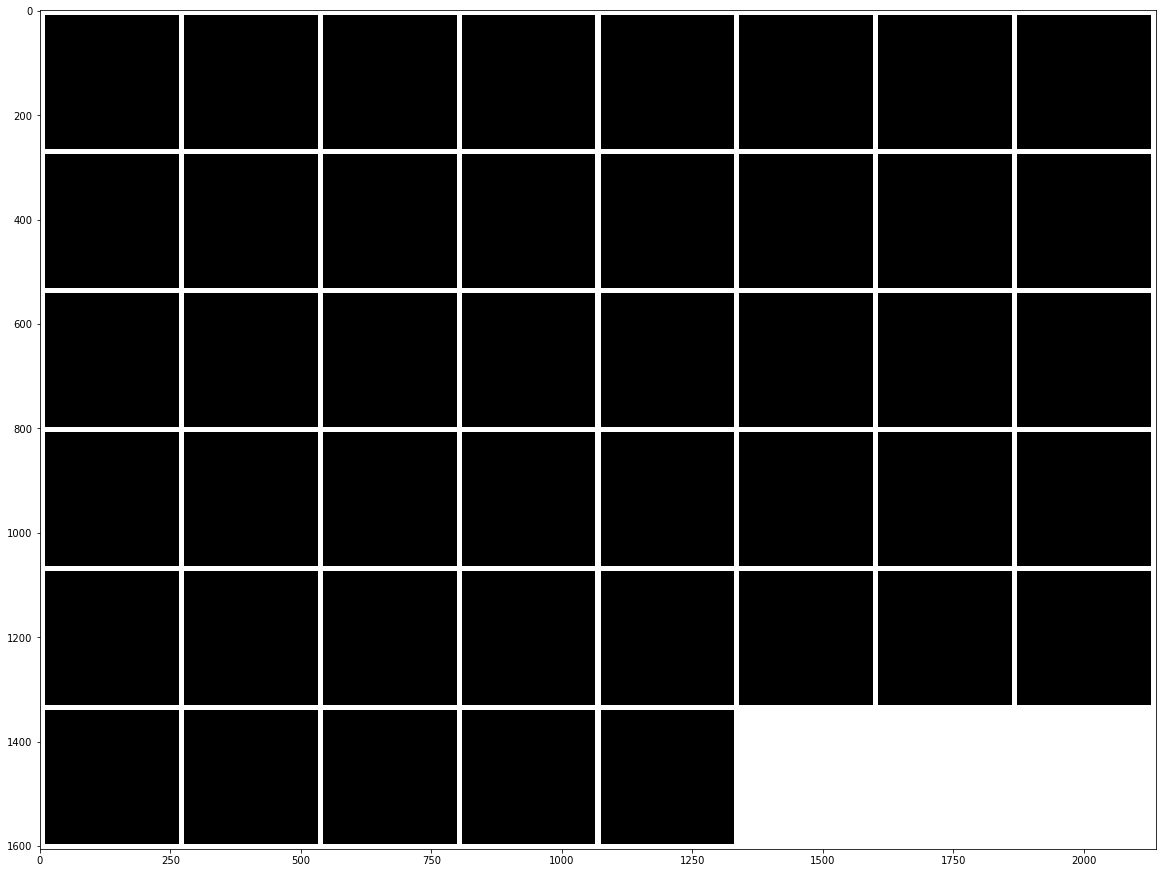

----------------------------------------------------------------------------------------------------
Ground Truth


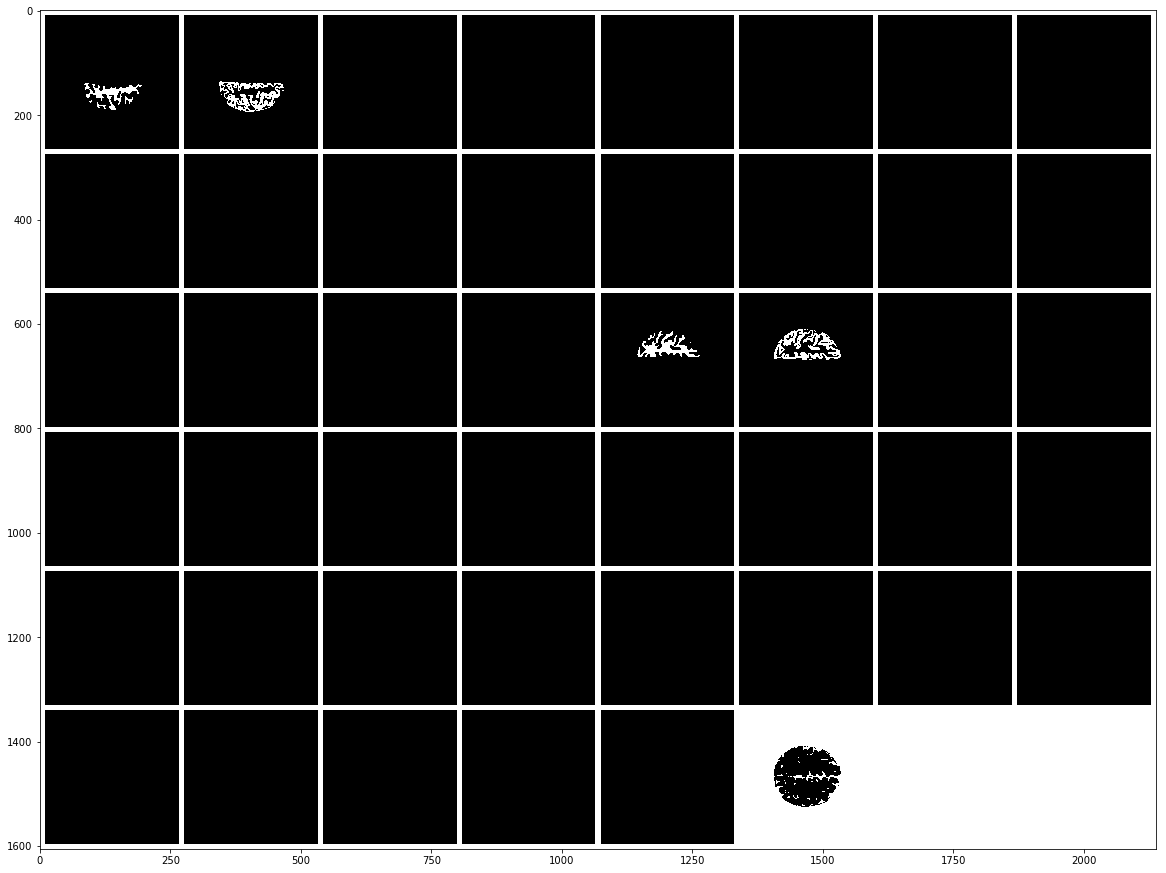

----------------------------------------------------------------------------------------------------
Prediction


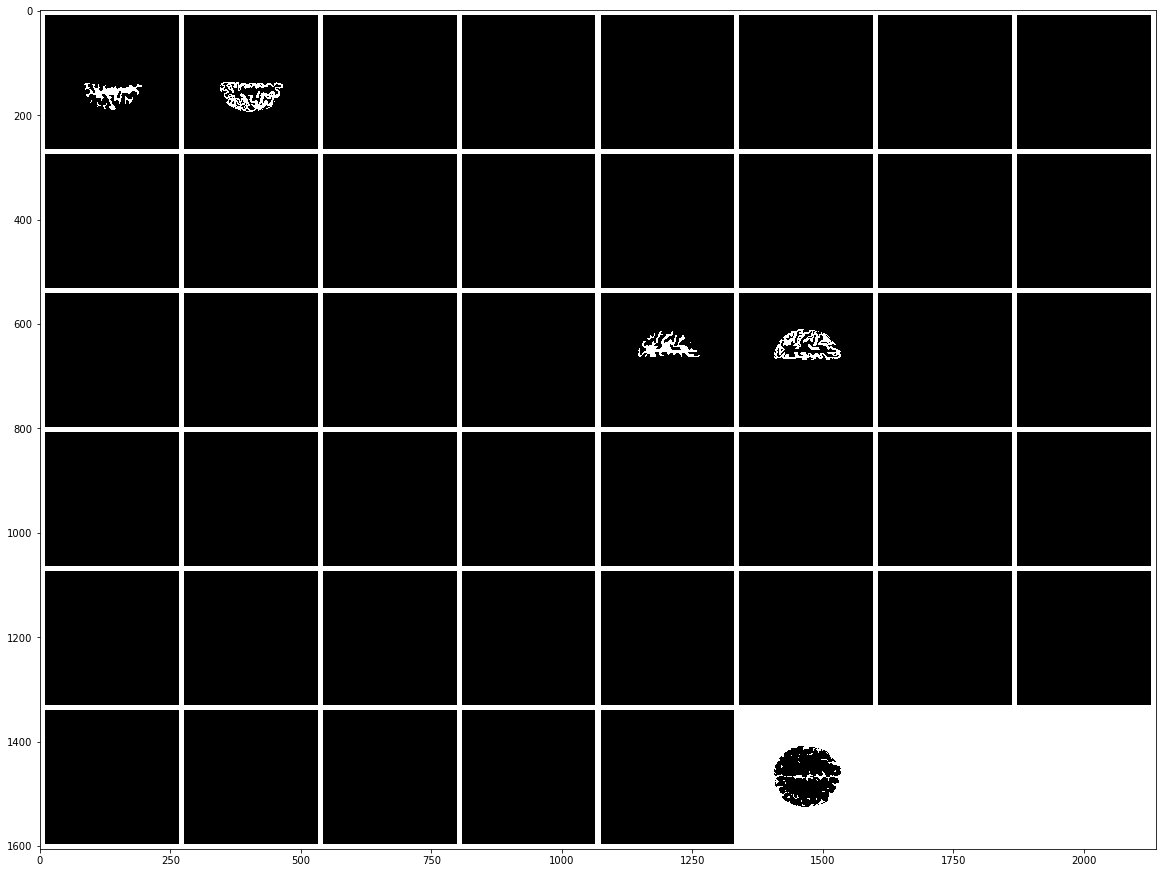

----------------------------------------------------------------------------------------------------
Ground Truth


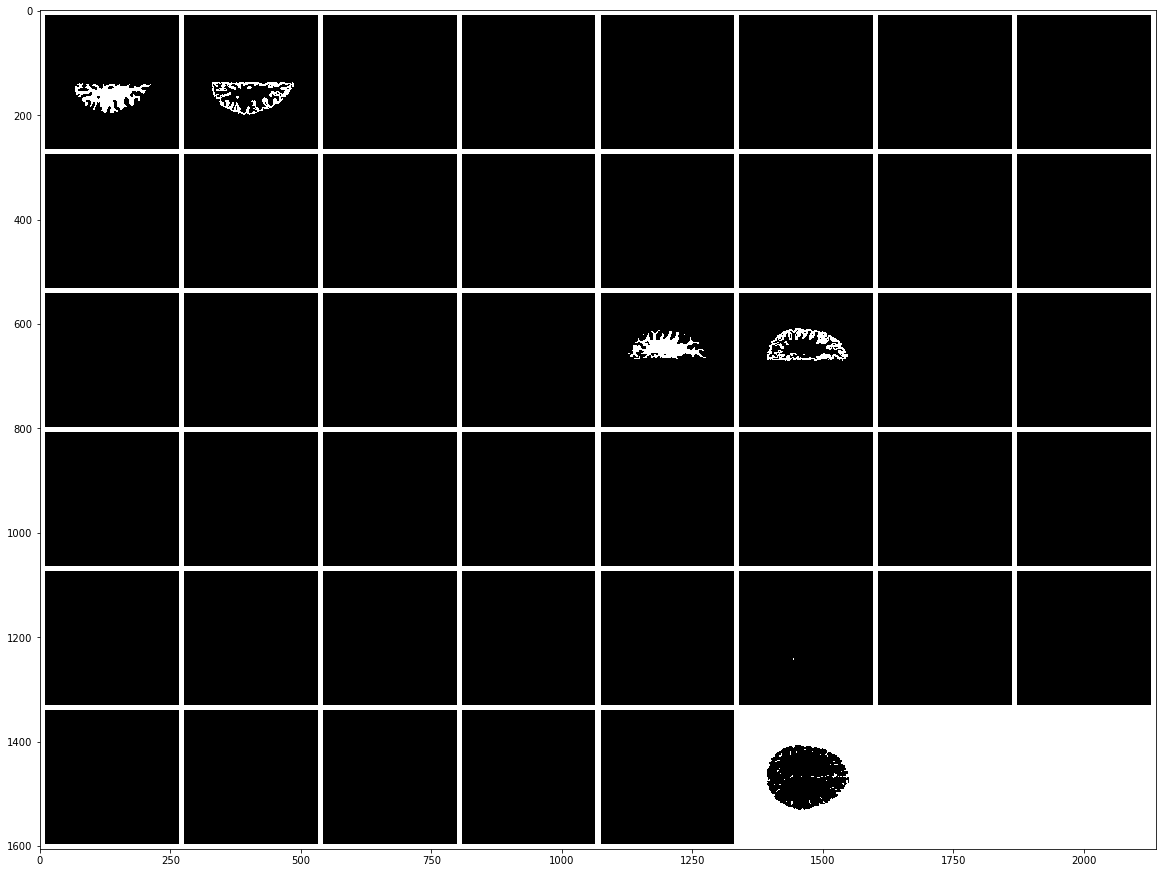

----------------------------------------------------------------------------------------------------
Prediction


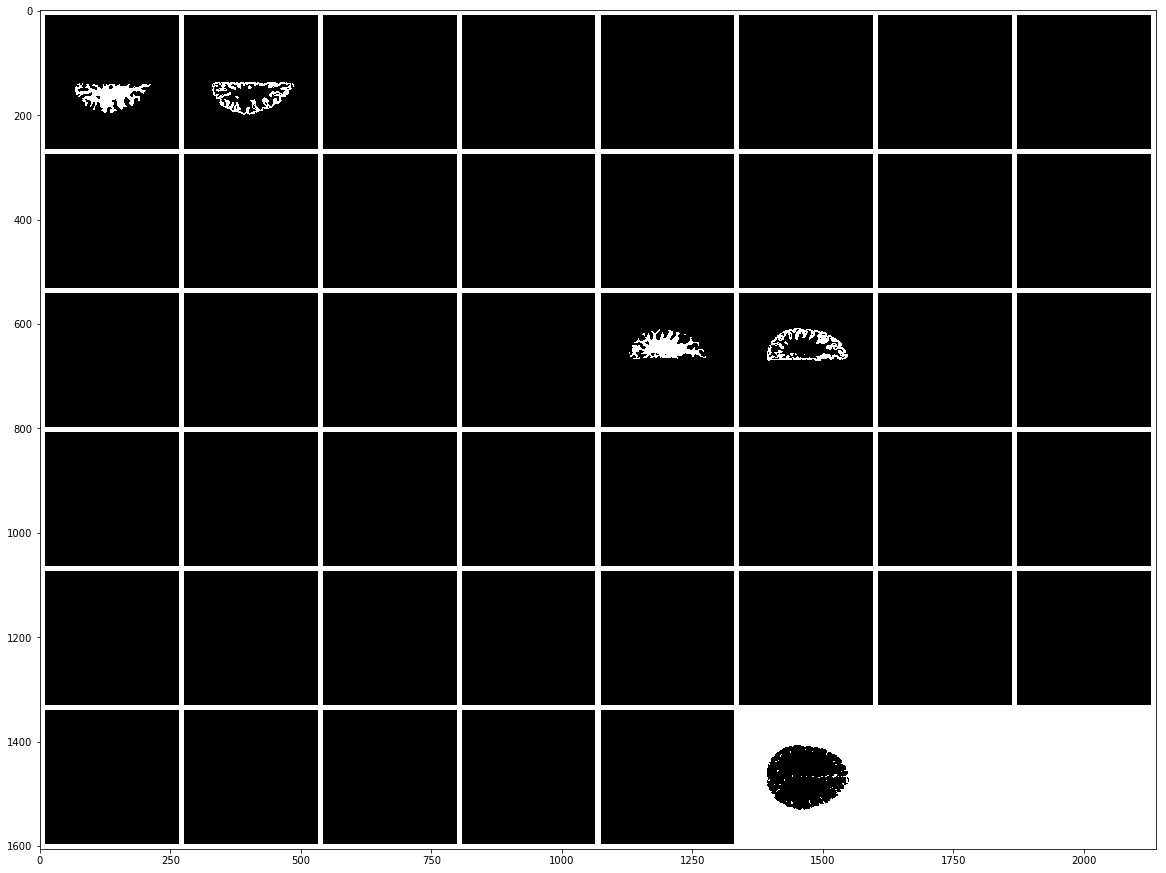

----------------------------------------------------------------------------------------------------
Ground Truth


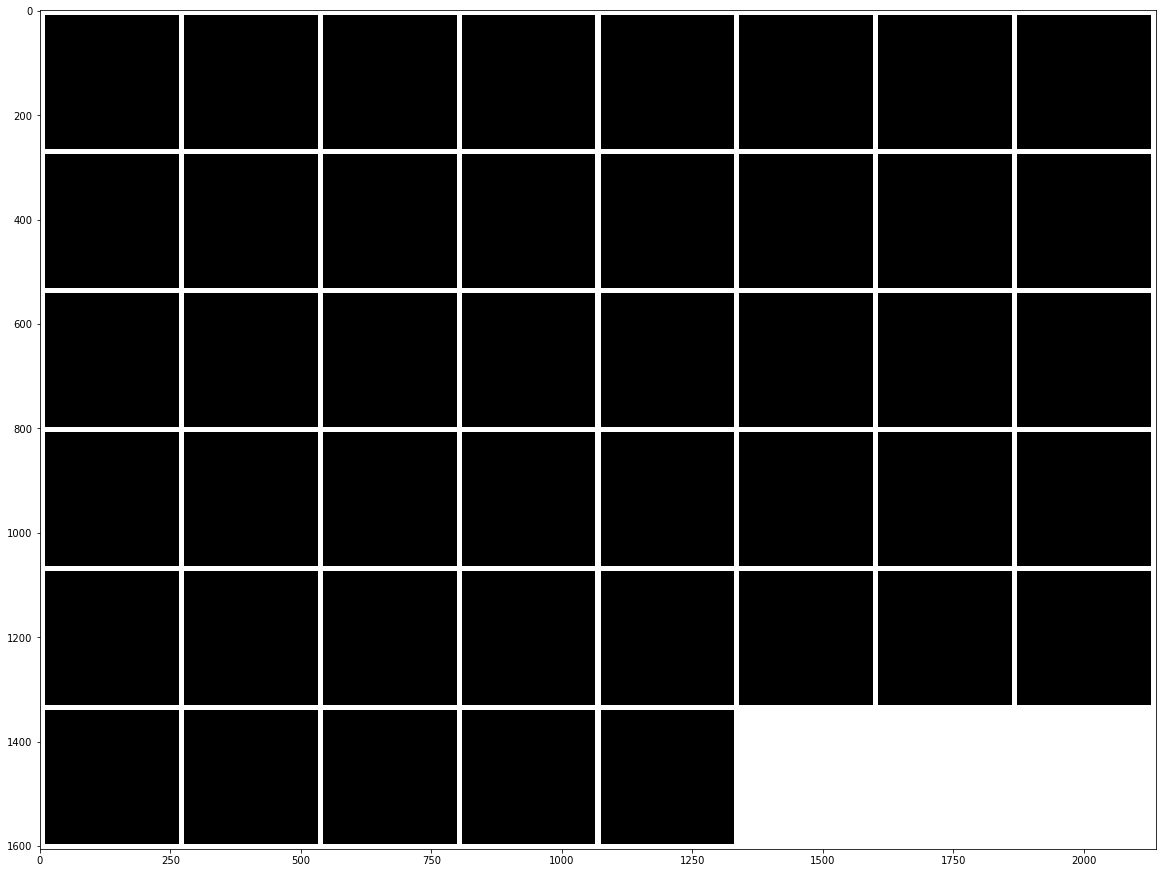

----------------------------------------------------------------------------------------------------
Prediction


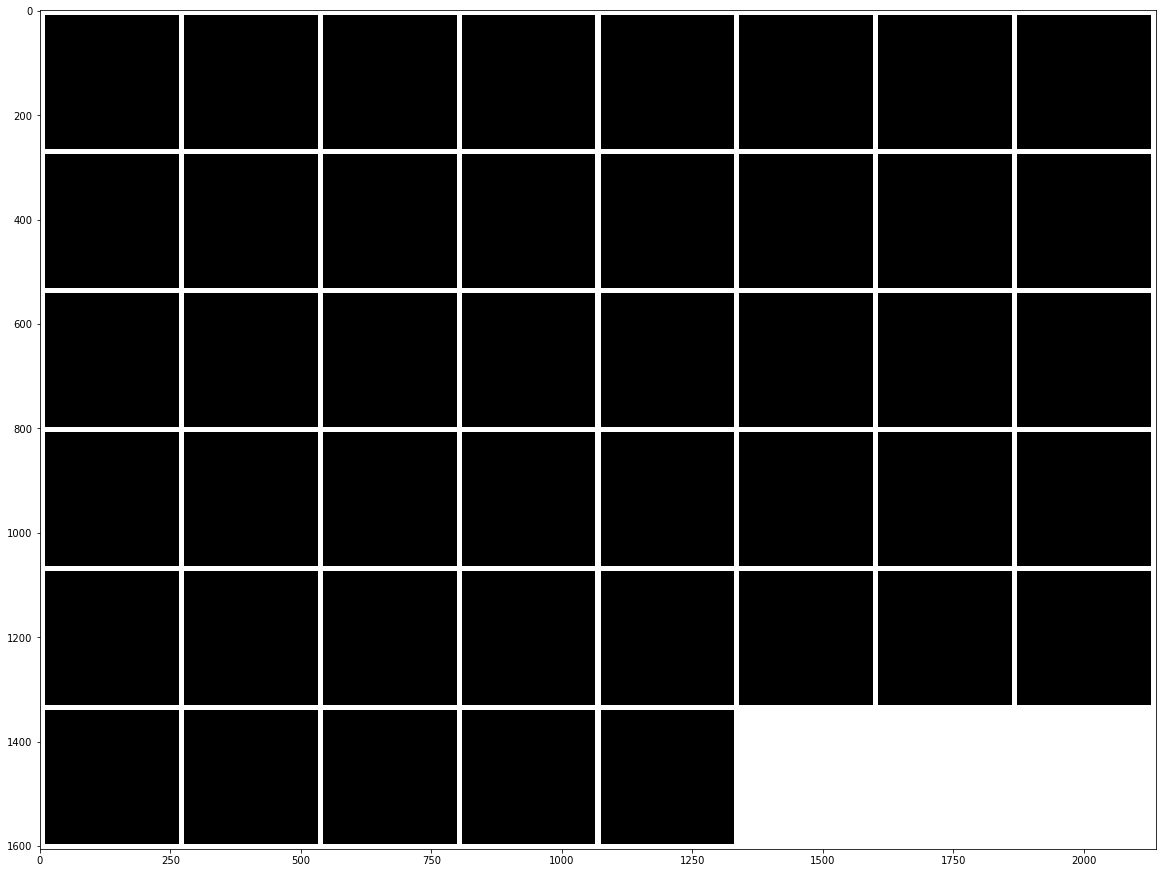

----------------------------------------------------------------------------------------------------
Ground Truth


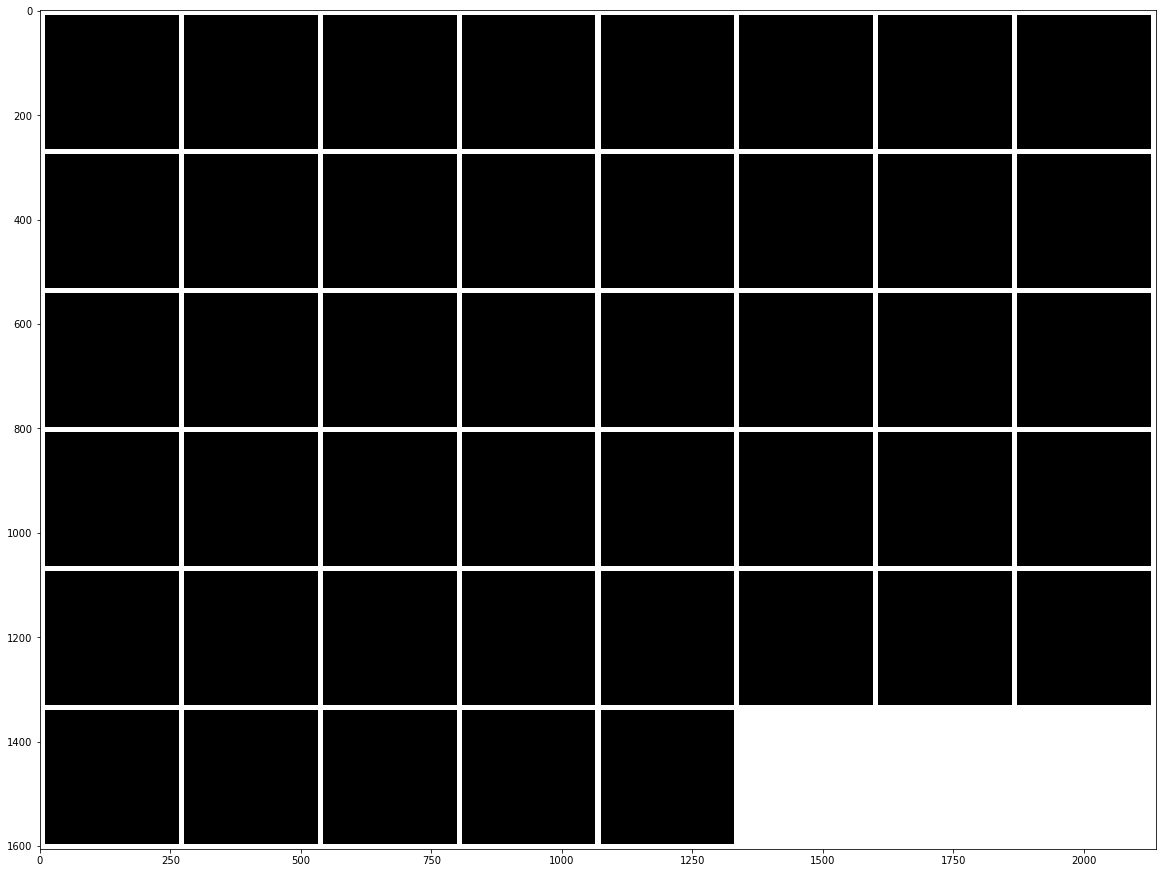

----------------------------------------------------------------------------------------------------
Prediction


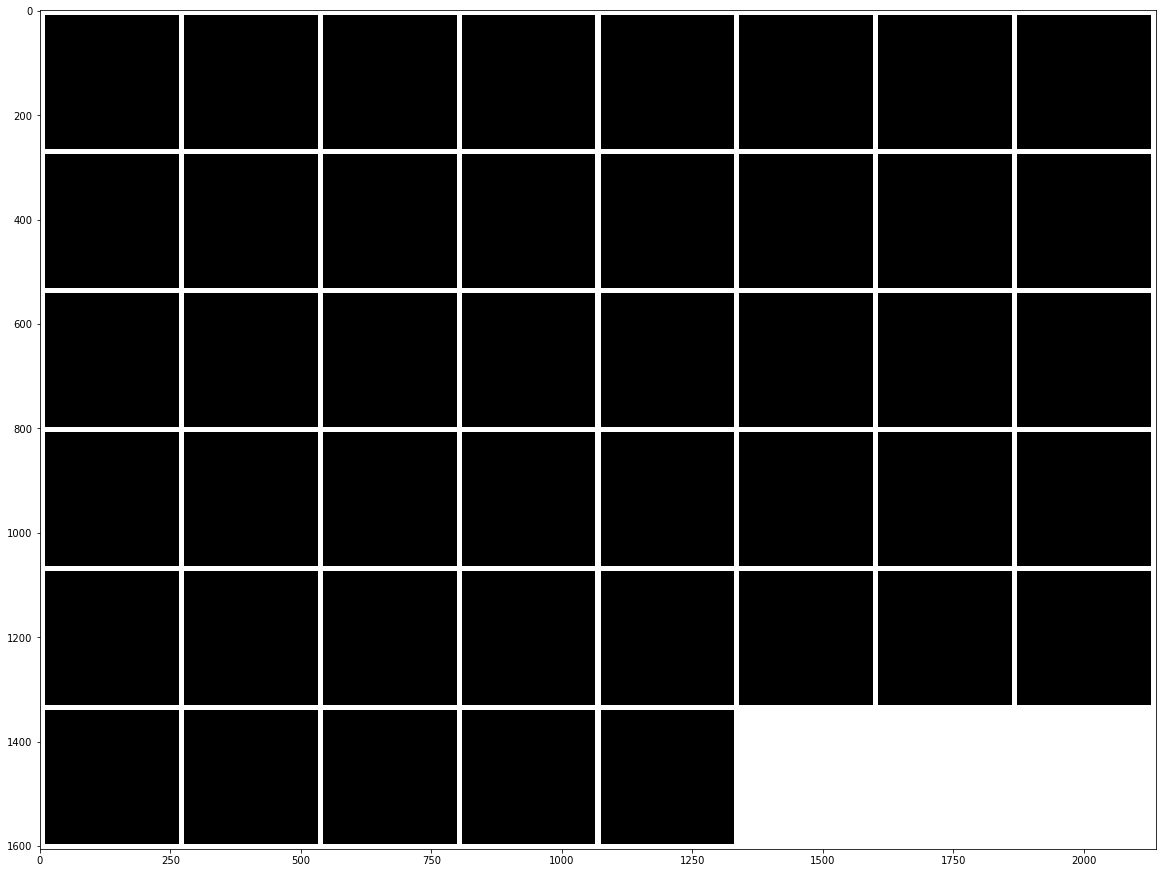

In [41]:
visualize_few()